# Install & Imports

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=908928a6d164436b11be776f67fc5cdfd762626ee8c5755515d14ac79a12be54
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm
import chardet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Preproccess

## Links between stations and rivers

In [ ]:
link_of_rain_station_to_river = pd.read_csv('link_of_rain_station_to_river_preprocess.csv')
link_of_rain_station_to_river.rename(columns={
    'תחנת גשם': 'rain_station',
    'נחל': 'river_name_hebrew',
    'מינימום זמן ליצירת שטפון': 'min_time_to_flow',
    'מקסימום זמן ליצירת שטפון': 'max_time_to_flow',
}, inplace=True)

## Functions

In [ ]:
def func_flow_in_river(file_csv, river_name):

  # Function to detect encoding
  def detect_encoding(file_path):
      with open(file_path, 'rb') as f:
          result = chardet.detect(f.read())
      return result['encoding']

  # # File paths
  # flow_in_river_file = '/content/flow_in_zihor_river_2010_to_2019_hebrew.csv'

  # Detect encoding
  flow_in_river_encoding = detect_encoding(file_csv)
  #print(flow_in_river_encoding)
  # Load the CSV file
  flow_in_river = pd.read_csv(file_csv, encoding=flow_in_river_encoding)



  flow_in_river.rename(columns={
      'שם תחנה': 'river_name_hebrew',
      'שם תחנה באנגלית': 'river_name_english',
      'זמן מדידת ספיקה': 'flow_time',
      '''ספיקה (מ''ק/שנייה)''': 'flow_amount'
  }, inplace=True)

  flow_in_river = flow_in_river[flow_in_river['river_name_hebrew'] == river_name]
  flow_in_river = flow_in_river[['river_name_hebrew', 'river_name_english', 'flow_time', 'flow_amount']]

  return flow_in_river

In [ ]:
def custom_rolling_sum(data, window_size):
  # Implement your custom rolling sum logic here
  # For example, you can compute the rolling sum of squares
  data_np = data.values[1:]
  # weight_np = np.array([i for i in range(window_size - 1, 0, -1)])
  weight_np = np.array([i for i in range(1, window_size)])
  dot_product = np.dot(data_np, weight_np)
  return dot_product

In [ ]:
def preprocess_one_rain_file_to_df(file_csv, window_size_delta = 3):
  station_10min_rain = pd.read_csv(file_csv)

  if 'faran' in file_csv:
    station_10min_rain.rename(columns={
    'תחנה': 'rain_station',
    'תאריך ושעה (שעון קיץ)': 'start_rain',
    'לחות יחסית (%)': 'humidity',
    'טמפרטורה (C°)': 'temperature',
    'כמות גשם (מ"מ)': 'rain_amount'
    }, inplace=True)

    station_10min_rain['rain_station'] = station_10min_rain['rain_station'].replace('פארן עד 20060124', 'פארן')

  station_10min_rain = station_10min_rain[(station_10min_rain['rain_amount'] != '-') | (station_10min_rain['temperature'] != '-') | (station_10min_rain['humidity'] != '-')]

  station_10min_rain.reset_index(drop=True, inplace=True)

  # Convert columns to numeric where applicable
  numeric_columns = ['humidity', 'temperature', 'rain_amount']

  #replace - to values before
  station_10min_rain.replace('-', np.nan, inplace=True)
  for index, row in station_10min_rain.iterrows():
    if index > 0:
        for column in numeric_columns:
            if pd.isna(row[column]):
                station_10min_rain.at[index, column] = station_10min_rain.at[index - 1, column]




  station_10min_rain[numeric_columns] = station_10min_rain[numeric_columns].apply(pd.to_numeric)

  # Create a new DataFrame for the sliding window sums
  window_size = window_size_delta
  variance_column = 'rain_variance'  # New column for rain variance
  sliding_window_df = station_10min_rain[['rain_station', 'start_rain']].copy()

  # Calculate rolling window statistics
  sliding_window_df['rain_amount'] = station_10min_rain['rain_amount'].rolling(window=window_size).sum()
  sliding_window_df['humidity'] = station_10min_rain['humidity'].rolling(window=window_size).mean()
  sliding_window_df['temperature'] = station_10min_rain['temperature'].rolling(window=window_size).mean()
  sliding_window_df[variance_column] = station_10min_rain['rain_amount'].rolling(window=window_size).var()

  # Shift the 'תאריך ושעה (שעון קיץ)' by window_size - 1 to represent the start of the window
  sliding_window_df['start_rain'] = sliding_window_df['start_rain'].shift(window_size - 1)

  # Drop rows with NaN (due to rolling calculation)
  sliding_window_df.dropna(inplace=True)

  sliding_window_df['start_rain'] = pd.to_datetime(sliding_window_df['start_rain'], format='%d/%m/%Y %H:%M')
  sliding_window_df['end_rain'] = sliding_window_df['start_rain'] + timedelta(minutes=30)

  #make the column 12h before
  window_size_rain_before = 72
  sliding_window_df['avg_of_rain_12h_before'] = sliding_window_df['rain_amount'].rolling(window=window_size_rain_before).apply(custom_rolling_sum, args=(window_size_rain_before,))
  sliding_window_df['avg_of_rain_12h_before'] = sliding_window_df['avg_of_rain_12h_before'].shift(1)

  #make the column 3h before
  window_size_rain_before = 18
  sliding_window_df['avg_of_rain_3h_before'] = sliding_window_df['rain_amount'].rolling(window=window_size_rain_before).apply(custom_rolling_sum, args=(window_size_rain_before,))
  sliding_window_df['avg_of_rain_3h_before'] = sliding_window_df['avg_of_rain_3h_before'].shift(1)

  sliding_window_df = sliding_window_df.dropna()
  sliding_window_df = sliding_window_df[sliding_window_df['rain_amount'] > 0] # Maybe No???

  #merge df times steps
  merged_df = pd.merge(sliding_window_df, link_of_rain_station_to_river, on='rain_station', how='left')

  #merge df of flows
  merged_df = pd.merge(merged_df, flow_in_river, left_on='river_name_hebrew', right_on='river_name_hebrew', how='left')
  merged_df['flow_time'] = pd.to_datetime(merged_df['flow_time'], format='%d/%m/%Y %H:%M')

  merged_df = merged_df.dropna(subset=['river_name_english'])

  # merged_df = merged_df[merged_df['rain_amount'] != 0] Maybe yes???? 06/09/2023 night beacause cresh!!!

  time_difference_seconds = (merged_df['flow_time'] - merged_df['start_rain']).dt.total_seconds()

  first_row = link_of_rain_station_to_river.iloc[0]  # Get the first row
  min_time_to_flow = first_row['min_time_to_flow']
  max_time_to_flow = first_row['max_time_to_flow']

  min_time = 60 * 60 * min_time_to_flow
  max_time = 60 * 60 * max_time_to_flow
  mask = (min_time <= time_difference_seconds) & (time_difference_seconds <= max_time)

  merged_df['flow'] = mask.replace({False: 0, True: 1})

  # Create a mask to identify the first appearance of each record where 'flow' is 0
  first_zero_mask = merged_df['flow'] == 0

  # Filter the DataFrame to keep all records with 'flow' equal to 1
  filtered_df = merged_df[merged_df['flow'] == 1]

  # Append the first appearance of records where 'flow' is 0 to the filtered DataFrame
  filtered_df = pd.concat([filtered_df, merged_df[first_zero_mask].drop_duplicates(subset='start_rain')])

  return filtered_df

# Create dataframes for stations + rivers

In [ ]:
for index,row in link_of_rain_station_to_river.iterrows():
  river_name = row['river_name_hebrew']
  station_name = row['rain_station']
  if station_name == 'פארן':
    station_name = 'faran'
  final_df = pd.DataFrame()
  flow_in_river = func_flow_in_river('/content/flow_in_river_2000_to_2010_hebrew.csv', river_name)
  for i in tqdm(range(2000, 2011)):
    try:
      df_i = preprocess_one_rain_file_to_df(f"/content/{station_name}_station_10min_rain_0109{i}_0106{i+1}.csv")
      print(f"/content/{station_name}_station_10min_rain_0109{i}_0106{i+1}.csv")
      final_df = pd.concat([final_df, df_i])
    except:
      pass

  flow_in_river = func_flow_in_river('/content/flow_in_river_2010_to_2019_hebrew.csv', river_name)
  for i in tqdm(range(2010, 2020)):
    try:
      df_i = preprocess_one_rain_file_to_df(f"/content/{station_name}_station_10min_rain_0109{i}_0106{i+1}.csv")
      print(f"/content/{station_name}_station_10min_rain_0109{i}_0106{i+1}.csv")
      final_df = pd.concat([final_df, df_i])
    except:
      pass
  flow_in_river = func_flow_in_river('/content/flow_in_river_2019_to_2021_hebrew.csv', river_name)
  for i in tqdm(range(2019, 2022)):
    try:
      df_i = preprocess_one_rain_file_to_df(f"/content/{station_name}_station_10min_rain_0109{i}_0106{i+1}.csv")
      print(f"/content/{station_name}_station_10min_rain_0109{i}_0106{i+1}.csv")
      final_df = pd.concat([final_df, df_i])
    except:
      pass
  # Save the DataFrame to a pickle file
  with open(f"/content/drive/MyDrive/mikiProject/dataframes for models/{station_name}_{river_name}_df.pkl", 'wb') as file:
      pickle.dump(final_df, file)


  9%|▉         | 1/11 [00:05<00:59,  5.92s/it]

/content/faran_station_10min_rain_01092000_01062001.csv


 18%|█▊        | 2/11 [00:11<00:50,  5.56s/it]

/content/faran_station_10min_rain_01092001_01062002.csv


 27%|██▋       | 3/11 [00:16<00:43,  5.45s/it]

/content/faran_station_10min_rain_01092002_01062003.csv


 36%|███▋      | 4/11 [00:21<00:37,  5.41s/it]

/content/faran_station_10min_rain_01092003_01062004.csv


 45%|████▌     | 5/11 [00:27<00:32,  5.38s/it]

/content/faran_station_10min_rain_01092004_01062005.csv


 55%|█████▍    | 6/11 [00:33<00:27,  5.58s/it]

/content/faran_station_10min_rain_01092005_01062006.csv


 64%|██████▎   | 7/11 [00:38<00:22,  5.50s/it]

/content/faran_station_10min_rain_01092006_01062007.csv


 73%|███████▎  | 8/11 [00:43<00:16,  5.39s/it]

/content/faran_station_10min_rain_01092007_01062008.csv


 82%|████████▏ | 9/11 [00:48<00:10,  5.35s/it]

/content/faran_station_10min_rain_01092008_01062009.csv


 91%|█████████ | 10/11 [00:54<00:05,  5.32s/it]

/content/faran_station_10min_rain_01092009_01062010.csv


100%|██████████| 11/11 [00:59<00:00,  5.40s/it]

/content/faran_station_10min_rain_01092010_01062011.csv



 10%|█         | 1/10 [00:05<00:48,  5.41s/it]

/content/faran_station_10min_rain_01092010_01062011.csv


 20%|██        | 2/10 [00:10<00:44,  5.51s/it]

/content/faran_station_10min_rain_01092011_01062012.csv


 30%|███       | 3/10 [00:16<00:37,  5.43s/it]

/content/faran_station_10min_rain_01092012_01062013.csv


 40%|████      | 4/10 [00:22<00:34,  5.68s/it]

/content/faran_station_10min_rain_01092013_01062014.csv


 50%|█████     | 5/10 [00:28<00:28,  5.66s/it]

/content/faran_station_10min_rain_01092014_01062015.csv


 60%|██████    | 6/10 [00:33<00:22,  5.65s/it]

/content/faran_station_10min_rain_01092015_01062016.csv


 70%|███████   | 7/10 [00:39<00:17,  5.71s/it]

/content/faran_station_10min_rain_01092016_01062017.csv


 80%|████████  | 8/10 [00:45<00:11,  5.66s/it]

/content/faran_station_10min_rain_01092017_01062018.csv


 90%|█████████ | 9/10 [00:50<00:05,  5.64s/it]

/content/faran_station_10min_rain_01092018_01062019.csv


100%|██████████| 10/10 [00:56<00:00,  5.66s/it]

/content/faran_station_10min_rain_01092019_01062020.csv



 33%|███▎      | 1/3 [00:05<00:10,  5.38s/it]

/content/faran_station_10min_rain_01092019_01062020.csv


 67%|██████▋   | 2/3 [00:10<00:05,  5.37s/it]

/content/faran_station_10min_rain_01092020_01062021.csv


100%|██████████| 3/3 [00:15<00:00,  5.32s/it]

/content/faran_station_10min_rain_01092021_01062022.csv



  9%|▉         | 1/11 [00:06<01:01,  6.20s/it]

/content/faran_station_10min_rain_01092000_01062001.csv


 18%|█▊        | 2/11 [00:11<00:51,  5.71s/it]

/content/faran_station_10min_rain_01092001_01062002.csv


 27%|██▋       | 3/11 [00:16<00:44,  5.56s/it]

/content/faran_station_10min_rain_01092002_01062003.csv


 36%|███▋      | 4/11 [00:22<00:39,  5.58s/it]

/content/faran_station_10min_rain_01092003_01062004.csv


 45%|████▌     | 5/11 [00:28<00:33,  5.57s/it]

/content/faran_station_10min_rain_01092004_01062005.csv


 55%|█████▍    | 6/11 [00:34<00:28,  5.73s/it]

/content/faran_station_10min_rain_01092005_01062006.csv


 64%|██████▎   | 7/11 [00:39<00:22,  5.63s/it]

/content/faran_station_10min_rain_01092006_01062007.csv


 73%|███████▎  | 8/11 [00:45<00:16,  5.58s/it]

/content/faran_station_10min_rain_01092007_01062008.csv


 82%|████████▏ | 9/11 [00:50<00:10,  5.50s/it]

/content/faran_station_10min_rain_01092008_01062009.csv


 91%|█████████ | 10/11 [00:55<00:05,  5.51s/it]

/content/faran_station_10min_rain_01092009_01062010.csv


100%|██████████| 11/11 [01:01<00:00,  5.58s/it]

/content/faran_station_10min_rain_01092010_01062011.csv



 10%|█         | 1/10 [00:05<00:50,  5.59s/it]

/content/faran_station_10min_rain_01092010_01062011.csv


 20%|██        | 2/10 [00:11<00:44,  5.58s/it]

/content/faran_station_10min_rain_01092011_01062012.csv


 30%|███       | 3/10 [00:16<00:38,  5.55s/it]

/content/faran_station_10min_rain_01092012_01062013.csv


 40%|████      | 4/10 [00:22<00:35,  5.84s/it]

/content/faran_station_10min_rain_01092013_01062014.csv


 50%|█████     | 5/10 [00:28<00:29,  5.84s/it]

/content/faran_station_10min_rain_01092014_01062015.csv


 60%|██████    | 6/10 [00:34<00:23,  5.86s/it]

/content/faran_station_10min_rain_01092015_01062016.csv


 70%|███████   | 7/10 [00:40<00:17,  5.92s/it]

/content/faran_station_10min_rain_01092016_01062017.csv


 80%|████████  | 8/10 [00:46<00:11,  5.84s/it]

/content/faran_station_10min_rain_01092017_01062018.csv


 90%|█████████ | 9/10 [00:52<00:05,  5.84s/it]

/content/faran_station_10min_rain_01092018_01062019.csv


100%|██████████| 10/10 [00:58<00:00,  5.85s/it]

/content/faran_station_10min_rain_01092019_01062020.csv



 33%|███▎      | 1/3 [00:05<00:10,  5.31s/it]

/content/faran_station_10min_rain_01092019_01062020.csv


 67%|██████▋   | 2/3 [00:10<00:05,  5.29s/it]

/content/faran_station_10min_rain_01092020_01062021.csv


100%|██████████| 3/3 [00:15<00:00,  5.22s/it]

/content/faran_station_10min_rain_01092021_01062022.csv



  9%|▉         | 1/11 [00:06<01:00,  6.03s/it]

/content/faran_station_10min_rain_01092000_01062001.csv


 18%|█▊        | 2/11 [00:11<00:50,  5.58s/it]

/content/faran_station_10min_rain_01092001_01062002.csv


 27%|██▋       | 3/11 [00:16<00:43,  5.41s/it]

/content/faran_station_10min_rain_01092002_01062003.csv


 36%|███▋      | 4/11 [00:21<00:37,  5.39s/it]

/content/faran_station_10min_rain_01092003_01062004.csv


 45%|████▌     | 5/11 [00:27<00:32,  5.34s/it]

/content/faran_station_10min_rain_01092004_01062005.csv


 55%|█████▍    | 6/11 [00:33<00:27,  5.54s/it]

/content/faran_station_10min_rain_01092005_01062006.csv


 64%|██████▎   | 7/11 [00:38<00:21,  5.44s/it]

/content/faran_station_10min_rain_01092006_01062007.csv


 73%|███████▎  | 8/11 [00:43<00:16,  5.38s/it]

/content/faran_station_10min_rain_01092007_01062008.csv


 82%|████████▏ | 9/11 [00:48<00:10,  5.34s/it]

/content/faran_station_10min_rain_01092008_01062009.csv


 91%|█████████ | 10/11 [00:53<00:05,  5.29s/it]

/content/faran_station_10min_rain_01092009_01062010.csv


100%|██████████| 11/11 [00:59<00:00,  5.38s/it]

/content/faran_station_10min_rain_01092010_01062011.csv



 10%|█         | 1/10 [00:05<00:49,  5.51s/it]

/content/faran_station_10min_rain_01092010_01062011.csv


 20%|██        | 2/10 [00:11<00:44,  5.52s/it]

/content/faran_station_10min_rain_01092011_01062012.csv


 30%|███       | 3/10 [00:16<00:38,  5.47s/it]

/content/faran_station_10min_rain_01092012_01062013.csv


 40%|████      | 4/10 [00:22<00:34,  5.69s/it]

/content/faran_station_10min_rain_01092013_01062014.csv


 50%|█████     | 5/10 [00:28<00:28,  5.70s/it]

/content/faran_station_10min_rain_01092014_01062015.csv


 60%|██████    | 6/10 [00:33<00:22,  5.70s/it]

/content/faran_station_10min_rain_01092015_01062016.csv


 70%|███████   | 7/10 [00:39<00:17,  5.76s/it]

/content/faran_station_10min_rain_01092016_01062017.csv


 80%|████████  | 8/10 [00:45<00:11,  5.72s/it]

/content/faran_station_10min_rain_01092017_01062018.csv


 90%|█████████ | 9/10 [00:51<00:05,  5.71s/it]

/content/faran_station_10min_rain_01092018_01062019.csv


100%|██████████| 10/10 [00:57<00:00,  5.72s/it]

/content/faran_station_10min_rain_01092019_01062020.csv



 33%|███▎      | 1/3 [00:05<00:10,  5.30s/it]

/content/faran_station_10min_rain_01092019_01062020.csv


 67%|██████▋   | 2/3 [00:10<00:05,  5.27s/it]

/content/faran_station_10min_rain_01092020_01062021.csv


100%|██████████| 3/3 [00:15<00:00,  5.22s/it]

/content/faran_station_10min_rain_01092021_01062022.csv



  9%|▉         | 1/11 [00:06<01:00,  6.04s/it]

/content/faran_station_10min_rain_01092000_01062001.csv


 18%|█▊        | 2/11 [00:11<00:50,  5.59s/it]

/content/faran_station_10min_rain_01092001_01062002.csv


 27%|██▋       | 3/11 [00:16<00:43,  5.44s/it]

/content/faran_station_10min_rain_01092002_01062003.csv


 36%|███▋      | 4/11 [00:21<00:37,  5.35s/it]

/content/faran_station_10min_rain_01092003_01062004.csv


 45%|████▌     | 5/11 [00:27<00:31,  5.32s/it]

/content/faran_station_10min_rain_01092004_01062005.csv


 55%|█████▍    | 6/11 [00:33<00:27,  5.53s/it]

/content/faran_station_10min_rain_01092005_01062006.csv


 64%|██████▎   | 7/11 [00:38<00:21,  5.43s/it]

/content/faran_station_10min_rain_01092006_01062007.csv


 73%|███████▎  | 8/11 [00:43<00:16,  5.36s/it]

/content/faran_station_10min_rain_01092007_01062008.csv


 82%|████████▏ | 9/11 [00:48<00:10,  5.32s/it]

/content/faran_station_10min_rain_01092008_01062009.csv


 91%|█████████ | 10/11 [00:53<00:05,  5.29s/it]

/content/faran_station_10min_rain_01092009_01062010.csv


100%|██████████| 11/11 [00:59<00:00,  5.37s/it]

/content/faran_station_10min_rain_01092010_01062011.csv



 10%|█         | 1/10 [00:05<00:51,  5.70s/it]

/content/faran_station_10min_rain_01092010_01062011.csv


 20%|██        | 2/10 [00:11<00:45,  5.65s/it]

/content/faran_station_10min_rain_01092011_01062012.csv


 30%|███       | 3/10 [00:16<00:39,  5.59s/it]

/content/faran_station_10min_rain_01092012_01062013.csv


 40%|████      | 4/10 [00:23<00:35,  5.86s/it]

/content/faran_station_10min_rain_01092013_01062014.csv


 50%|█████     | 5/10 [00:29<00:29,  5.87s/it]

/content/faran_station_10min_rain_01092014_01062015.csv


 60%|██████    | 6/10 [00:34<00:23,  5.87s/it]

/content/faran_station_10min_rain_01092015_01062016.csv


 70%|███████   | 7/10 [00:40<00:17,  5.93s/it]

/content/faran_station_10min_rain_01092016_01062017.csv


 80%|████████  | 8/10 [00:46<00:11,  5.90s/it]

/content/faran_station_10min_rain_01092017_01062018.csv


 90%|█████████ | 9/10 [00:52<00:05,  5.89s/it]

/content/faran_station_10min_rain_01092018_01062019.csv


100%|██████████| 10/10 [00:58<00:00,  5.89s/it]

/content/faran_station_10min_rain_01092019_01062020.csv



 33%|███▎      | 1/3 [00:05<00:10,  5.38s/it]

/content/faran_station_10min_rain_01092019_01062020.csv


 67%|██████▋   | 2/3 [00:10<00:05,  5.35s/it]

/content/faran_station_10min_rain_01092020_01062021.csv


100%|██████████| 3/3 [00:15<00:00,  5.24s/it]

/content/faran_station_10min_rain_01092021_01062022.csv



  9%|▉         | 1/11 [00:06<01:00,  6.05s/it]

/content/faran_station_10min_rain_01092000_01062001.csv


 18%|█▊        | 2/11 [00:11<00:49,  5.55s/it]

/content/faran_station_10min_rain_01092001_01062002.csv


 27%|██▋       | 3/11 [00:16<00:43,  5.41s/it]

/content/faran_station_10min_rain_01092002_01062003.csv


 36%|███▋      | 4/11 [00:21<00:37,  5.38s/it]

/content/faran_station_10min_rain_01092003_01062004.csv


 45%|████▌     | 5/11 [00:27<00:32,  5.35s/it]

/content/faran_station_10min_rain_01092004_01062005.csv


 55%|█████▍    | 6/11 [00:33<00:27,  5.55s/it]

/content/faran_station_10min_rain_01092005_01062006.csv


 64%|██████▎   | 7/11 [00:38<00:21,  5.45s/it]

/content/faran_station_10min_rain_01092006_01062007.csv


 73%|███████▎  | 8/11 [00:43<00:16,  5.40s/it]

/content/faran_station_10min_rain_01092007_01062008.csv


 82%|████████▏ | 9/11 [00:48<00:10,  5.35s/it]

/content/faran_station_10min_rain_01092008_01062009.csv


 91%|█████████ | 10/11 [00:54<00:05,  5.33s/it]

/content/faran_station_10min_rain_01092009_01062010.csv


100%|██████████| 11/11 [00:59<00:00,  5.40s/it]

/content/faran_station_10min_rain_01092010_01062011.csv



 10%|█         | 1/10 [00:05<00:48,  5.41s/it]

/content/faran_station_10min_rain_01092010_01062011.csv


 20%|██        | 2/10 [00:10<00:43,  5.44s/it]

/content/faran_station_10min_rain_01092011_01062012.csv


 30%|███       | 3/10 [00:16<00:37,  5.39s/it]

/content/faran_station_10min_rain_01092012_01062013.csv


 40%|████      | 4/10 [00:22<00:33,  5.57s/it]

/content/faran_station_10min_rain_01092013_01062014.csv


 50%|█████     | 5/10 [00:27<00:27,  5.58s/it]

/content/faran_station_10min_rain_01092014_01062015.csv


 60%|██████    | 6/10 [00:33<00:22,  5.60s/it]

/content/faran_station_10min_rain_01092015_01062016.csv


 70%|███████   | 7/10 [00:38<00:16,  5.63s/it]

/content/faran_station_10min_rain_01092016_01062017.csv


 80%|████████  | 8/10 [00:44<00:11,  5.58s/it]

/content/faran_station_10min_rain_01092017_01062018.csv


 90%|█████████ | 9/10 [00:50<00:05,  5.57s/it]

/content/faran_station_10min_rain_01092018_01062019.csv


100%|██████████| 10/10 [00:55<00:00,  5.57s/it]

/content/faran_station_10min_rain_01092019_01062020.csv



 33%|███▎      | 1/3 [00:05<00:10,  5.24s/it]

/content/faran_station_10min_rain_01092019_01062020.csv


 67%|██████▋   | 2/3 [00:10<00:05,  5.22s/it]

/content/faran_station_10min_rain_01092020_01062021.csv


100%|██████████| 3/3 [00:15<00:00,  5.15s/it]

/content/faran_station_10min_rain_01092021_01062022.csv



  9%|▉         | 1/11 [00:05<00:53,  5.38s/it]

/content/mizpe_ramon_station_10min_rain_01092000_01062001.csv


 18%|█▊        | 2/11 [00:11<00:50,  5.62s/it]

/content/mizpe_ramon_station_10min_rain_01092001_01062002.csv


 27%|██▋       | 3/11 [00:17<00:46,  5.79s/it]

/content/mizpe_ramon_station_10min_rain_01092002_01062003.csv


 36%|███▋      | 4/11 [00:23<00:41,  5.86s/it]

/content/mizpe_ramon_station_10min_rain_01092003_01062004.csv


 45%|████▌     | 5/11 [00:29<00:35,  5.89s/it]

/content/mizpe_ramon_station_10min_rain_01092004_01062005.csv


 55%|█████▍    | 6/11 [00:34<00:29,  5.85s/it]

/content/mizpe_ramon_station_10min_rain_01092005_01062006.csv


 64%|██████▎   | 7/11 [00:40<00:23,  5.94s/it]

/content/mizpe_ramon_station_10min_rain_01092006_01062007.csv


 73%|███████▎  | 8/11 [00:46<00:17,  5.78s/it]

/content/mizpe_ramon_station_10min_rain_01092007_01062008.csv


 82%|████████▏ | 9/11 [00:51<00:11,  5.70s/it]

/content/mizpe_ramon_station_10min_rain_01092008_01062009.csv


 91%|█████████ | 10/11 [00:57<00:05,  5.80s/it]

/content/mizpe_ramon_station_10min_rain_01092009_01062010.csv


100%|██████████| 11/11 [01:03<00:00,  5.80s/it]

/content/mizpe_ramon_station_10min_rain_01092010_01062011.csv



 10%|█         | 1/10 [00:05<00:53,  5.98s/it]

/content/mizpe_ramon_station_10min_rain_01092010_01062011.csv


 20%|██        | 2/10 [00:11<00:44,  5.56s/it]

/content/mizpe_ramon_station_10min_rain_01092011_01062012.csv


 30%|███       | 3/10 [00:11<00:22,  3.27s/it]

/content/mizpe_ramon_station_10min_rain_01092012_01062013.csv


 40%|████      | 4/10 [00:12<00:13,  2.20s/it]

/content/mizpe_ramon_station_10min_rain_01092013_01062014.csv


 50%|█████     | 5/10 [00:12<00:07,  1.60s/it]

/content/mizpe_ramon_station_10min_rain_01092014_01062015.csv


 60%|██████    | 6/10 [00:13<00:04,  1.24s/it]

/content/mizpe_ramon_station_10min_rain_01092015_01062016.csv


 70%|███████   | 7/10 [00:15<00:04,  1.42s/it]

/content/mizpe_ramon_station_10min_rain_01092016_01062017.csv


 80%|████████  | 8/10 [00:21<00:05,  2.94s/it]

/content/mizpe_ramon_station_10min_rain_01092017_01062018.csv


 90%|█████████ | 9/10 [00:27<00:03,  3.95s/it]

/content/mizpe_ramon_station_10min_rain_01092018_01062019.csv


100%|██████████| 10/10 [00:34<00:00,  3.44s/it]

/content/mizpe_ramon_station_10min_rain_01092019_01062020.csv



 33%|███▎      | 1/3 [00:05<00:10,  5.26s/it]

/content/mizpe_ramon_station_10min_rain_01092019_01062020.csv


 67%|██████▋   | 2/3 [00:10<00:05,  5.21s/it]

/content/mizpe_ramon_station_10min_rain_01092020_01062021.csv


100%|██████████| 3/3 [00:15<00:00,  5.20s/it]

/content/mizpe_ramon_station_10min_rain_01092021_01062022.csv



  9%|▉         | 1/11 [00:04<00:48,  4.84s/it]

/content/mizpe_ramon_station_10min_rain_01092000_01062001.csv


 18%|█▊        | 2/11 [00:10<00:45,  5.07s/it]

/content/mizpe_ramon_station_10min_rain_01092001_01062002.csv


 27%|██▋       | 3/11 [00:15<00:41,  5.16s/it]

/content/mizpe_ramon_station_10min_rain_01092002_01062003.csv


 36%|███▋      | 4/11 [00:20<00:36,  5.19s/it]

/content/mizpe_ramon_station_10min_rain_01092003_01062004.csv


 45%|████▌     | 5/11 [00:25<00:31,  5.21s/it]

/content/mizpe_ramon_station_10min_rain_01092004_01062005.csv


 55%|█████▍    | 6/11 [00:31<00:26,  5.21s/it]

/content/mizpe_ramon_station_10min_rain_01092005_01062006.csv


 64%|██████▎   | 7/11 [00:36<00:20,  5.25s/it]

/content/mizpe_ramon_station_10min_rain_01092006_01062007.csv


 73%|███████▎  | 8/11 [00:41<00:15,  5.09s/it]

/content/mizpe_ramon_station_10min_rain_01092007_01062008.csv


 82%|████████▏ | 9/11 [00:46<00:10,  5.13s/it]

/content/mizpe_ramon_station_10min_rain_01092008_01062009.csv


 91%|█████████ | 10/11 [00:51<00:05,  5.17s/it]

/content/mizpe_ramon_station_10min_rain_01092009_01062010.csv


100%|██████████| 11/11 [00:56<00:00,  5.17s/it]

/content/mizpe_ramon_station_10min_rain_01092010_01062011.csv



 10%|█         | 1/10 [00:06<00:56,  6.23s/it]

/content/mizpe_ramon_station_10min_rain_01092010_01062011.csv


 20%|██        | 2/10 [00:11<00:45,  5.74s/it]

/content/mizpe_ramon_station_10min_rain_01092011_01062012.csv


 30%|███       | 3/10 [00:12<00:23,  3.37s/it]

/content/mizpe_ramon_station_10min_rain_01092012_01062013.csv


 40%|████      | 4/10 [00:12<00:13,  2.25s/it]

/content/mizpe_ramon_station_10min_rain_01092013_01062014.csv


 50%|█████     | 5/10 [00:13<00:08,  1.64s/it]

/content/mizpe_ramon_station_10min_rain_01092014_01062015.csv


 60%|██████    | 6/10 [00:13<00:05,  1.27s/it]

/content/mizpe_ramon_station_10min_rain_01092015_01062016.csv


 70%|███████   | 7/10 [00:15<00:04,  1.46s/it]

/content/mizpe_ramon_station_10min_rain_01092016_01062017.csv


 80%|████████  | 8/10 [00:22<00:06,  3.04s/it]

/content/mizpe_ramon_station_10min_rain_01092017_01062018.csv


 90%|█████████ | 9/10 [00:28<00:04,  4.06s/it]

/content/mizpe_ramon_station_10min_rain_01092018_01062019.csv


100%|██████████| 10/10 [00:35<00:00,  3.57s/it]

/content/mizpe_ramon_station_10min_rain_01092019_01062020.csv



 33%|███▎      | 1/3 [00:05<00:10,  5.39s/it]

/content/mizpe_ramon_station_10min_rain_01092019_01062020.csv


 67%|██████▋   | 2/3 [00:10<00:05,  5.24s/it]

/content/mizpe_ramon_station_10min_rain_01092020_01062021.csv


100%|██████████| 3/3 [00:15<00:00,  5.23s/it]

/content/mizpe_ramon_station_10min_rain_01092021_01062022.csv



  9%|▉         | 1/11 [00:05<00:53,  5.39s/it]

/content/mizpe_ramon_station_10min_rain_01092000_01062001.csv


 18%|█▊        | 2/11 [00:11<00:50,  5.63s/it]

/content/mizpe_ramon_station_10min_rain_01092001_01062002.csv


 27%|██▋       | 3/11 [00:17<00:46,  5.85s/it]

/content/mizpe_ramon_station_10min_rain_01092002_01062003.csv


 36%|███▋      | 4/11 [00:23<00:41,  5.93s/it]

/content/mizpe_ramon_station_10min_rain_01092003_01062004.csv


 45%|████▌     | 5/11 [00:29<00:35,  5.96s/it]

/content/mizpe_ramon_station_10min_rain_01092004_01062005.csv


 55%|█████▍    | 6/11 [00:35<00:29,  5.92s/it]

/content/mizpe_ramon_station_10min_rain_01092005_01062006.csv


 64%|██████▎   | 7/11 [00:41<00:24,  6.02s/it]

/content/mizpe_ramon_station_10min_rain_01092006_01062007.csv


 73%|███████▎  | 8/11 [00:46<00:17,  5.86s/it]

/content/mizpe_ramon_station_10min_rain_01092007_01062008.csv


 82%|████████▏ | 9/11 [00:52<00:11,  5.77s/it]

/content/mizpe_ramon_station_10min_rain_01092008_01062009.csv


 91%|█████████ | 10/11 [00:58<00:05,  5.87s/it]

/content/mizpe_ramon_station_10min_rain_01092009_01062010.csv


100%|██████████| 11/11 [01:04<00:00,  5.86s/it]

/content/mizpe_ramon_station_10min_rain_01092010_01062011.csv



 10%|█         | 1/10 [00:06<00:54,  6.03s/it]

/content/mizpe_ramon_station_10min_rain_01092010_01062011.csv


 20%|██        | 2/10 [00:11<00:44,  5.59s/it]

/content/mizpe_ramon_station_10min_rain_01092011_01062012.csv


 30%|███       | 3/10 [00:11<00:23,  3.29s/it]

/content/mizpe_ramon_station_10min_rain_01092012_01062013.csv


 40%|████      | 4/10 [00:12<00:13,  2.20s/it]

/content/mizpe_ramon_station_10min_rain_01092013_01062014.csv


 50%|█████     | 5/10 [00:12<00:08,  1.60s/it]

/content/mizpe_ramon_station_10min_rain_01092014_01062015.csv


 60%|██████    | 6/10 [00:13<00:04,  1.24s/it]

/content/mizpe_ramon_station_10min_rain_01092015_01062016.csv


 70%|███████   | 7/10 [00:15<00:04,  1.44s/it]

/content/mizpe_ramon_station_10min_rain_01092016_01062017.csv


 80%|████████  | 8/10 [00:21<00:05,  2.98s/it]

/content/mizpe_ramon_station_10min_rain_01092017_01062018.csv


 90%|█████████ | 9/10 [00:27<00:03,  3.95s/it]

/content/mizpe_ramon_station_10min_rain_01092018_01062019.csv


100%|██████████| 10/10 [00:34<00:00,  3.45s/it]

/content/mizpe_ramon_station_10min_rain_01092019_01062020.csv



 33%|███▎      | 1/3 [00:05<00:10,  5.31s/it]

/content/mizpe_ramon_station_10min_rain_01092019_01062020.csv


 67%|██████▋   | 2/3 [00:10<00:05,  5.23s/it]

/content/mizpe_ramon_station_10min_rain_01092020_01062021.csv


100%|██████████| 3/3 [00:15<00:00,  5.23s/it]

/content/mizpe_ramon_station_10min_rain_01092021_01062022.csv



  9%|▉         | 1/11 [00:04<00:48,  4.89s/it]

/content/mizpe_ramon_station_10min_rain_01092000_01062001.csv


 18%|█▊        | 2/11 [00:10<00:45,  5.07s/it]

/content/mizpe_ramon_station_10min_rain_01092001_01062002.csv


 27%|██▋       | 3/11 [00:15<00:40,  5.09s/it]

/content/mizpe_ramon_station_10min_rain_01092002_01062003.csv


 36%|███▋      | 4/11 [00:20<00:35,  5.08s/it]

/content/mizpe_ramon_station_10min_rain_01092003_01062004.csv


 45%|████▌     | 5/11 [00:25<00:30,  5.09s/it]

/content/mizpe_ramon_station_10min_rain_01092004_01062005.csv


 55%|█████▍    | 6/11 [00:30<00:25,  5.10s/it]

/content/mizpe_ramon_station_10min_rain_01092005_01062006.csv


 64%|██████▎   | 7/11 [00:35<00:20,  5.09s/it]

/content/mizpe_ramon_station_10min_rain_01092006_01062007.csv


 73%|███████▎  | 8/11 [00:40<00:14,  4.98s/it]

/content/mizpe_ramon_station_10min_rain_01092007_01062008.csv


 82%|████████▏ | 9/11 [00:45<00:10,  5.05s/it]

/content/mizpe_ramon_station_10min_rain_01092008_01062009.csv


 91%|█████████ | 10/11 [00:50<00:05,  5.08s/it]

/content/mizpe_ramon_station_10min_rain_01092009_01062010.csv


100%|██████████| 11/11 [00:55<00:00,  5.07s/it]

/content/mizpe_ramon_station_10min_rain_01092010_01062011.csv



 10%|█         | 1/10 [00:06<00:57,  6.37s/it]

/content/mizpe_ramon_station_10min_rain_01092010_01062011.csv


 20%|██        | 2/10 [00:11<00:46,  5.77s/it]

/content/mizpe_ramon_station_10min_rain_01092011_01062012.csv


 30%|███       | 3/10 [00:12<00:23,  3.39s/it]

/content/mizpe_ramon_station_10min_rain_01092012_01062013.csv


 40%|████      | 4/10 [00:12<00:13,  2.27s/it]

/content/mizpe_ramon_station_10min_rain_01092013_01062014.csv


 50%|█████     | 5/10 [00:13<00:08,  1.65s/it]

/content/mizpe_ramon_station_10min_rain_01092014_01062015.csv


 60%|██████    | 6/10 [00:13<00:05,  1.27s/it]

/content/mizpe_ramon_station_10min_rain_01092015_01062016.csv


 70%|███████   | 7/10 [00:15<00:04,  1.46s/it]

/content/mizpe_ramon_station_10min_rain_01092016_01062017.csv


 80%|████████  | 8/10 [00:22<00:06,  3.11s/it]

/content/mizpe_ramon_station_10min_rain_01092017_01062018.csv


 90%|█████████ | 9/10 [00:28<00:04,  4.17s/it]

/content/mizpe_ramon_station_10min_rain_01092018_01062019.csv


100%|██████████| 10/10 [00:36<00:00,  3.65s/it]

/content/mizpe_ramon_station_10min_rain_01092019_01062020.csv



 33%|███▎      | 1/3 [00:05<00:10,  5.25s/it]

/content/mizpe_ramon_station_10min_rain_01092019_01062020.csv


 67%|██████▋   | 2/3 [00:10<00:05,  5.24s/it]

/content/mizpe_ramon_station_10min_rain_01092020_01062021.csv


100%|██████████| 3/3 [00:15<00:00,  5.22s/it]

/content/mizpe_ramon_station_10min_rain_01092021_01062022.csv



  9%|▉         | 1/11 [00:04<00:49,  4.90s/it]

/content/mizpe_ramon_station_10min_rain_01092000_01062001.csv


 18%|█▊        | 2/11 [00:10<00:45,  5.03s/it]

/content/mizpe_ramon_station_10min_rain_01092001_01062002.csv


 27%|██▋       | 3/11 [00:15<00:40,  5.12s/it]

/content/mizpe_ramon_station_10min_rain_01092002_01062003.csv


 36%|███▋      | 4/11 [00:20<00:35,  5.14s/it]

/content/mizpe_ramon_station_10min_rain_01092003_01062004.csv


 45%|████▌     | 5/11 [00:25<00:31,  5.19s/it]

/content/mizpe_ramon_station_10min_rain_01092004_01062005.csv


 55%|█████▍    | 6/11 [00:30<00:25,  5.15s/it]

/content/mizpe_ramon_station_10min_rain_01092005_01062006.csv


 64%|██████▎   | 7/11 [00:35<00:20,  5.16s/it]

/content/mizpe_ramon_station_10min_rain_01092006_01062007.csv


 73%|███████▎  | 8/11 [00:40<00:15,  5.01s/it]

/content/mizpe_ramon_station_10min_rain_01092007_01062008.csv


 82%|████████▏ | 9/11 [00:45<00:10,  5.05s/it]

/content/mizpe_ramon_station_10min_rain_01092008_01062009.csv


 91%|█████████ | 10/11 [00:50<00:05,  5.08s/it]

/content/mizpe_ramon_station_10min_rain_01092009_01062010.csv


100%|██████████| 11/11 [00:56<00:00,  5.11s/it]

/content/mizpe_ramon_station_10min_rain_01092010_01062011.csv



 10%|█         | 1/10 [00:06<00:54,  6.08s/it]

/content/mizpe_ramon_station_10min_rain_01092010_01062011.csv


 20%|██        | 2/10 [00:11<00:45,  5.63s/it]

/content/mizpe_ramon_station_10min_rain_01092011_01062012.csv


 30%|███       | 3/10 [00:11<00:23,  3.30s/it]

/content/mizpe_ramon_station_10min_rain_01092012_01062013.csv


 40%|████      | 4/10 [00:12<00:13,  2.21s/it]

/content/mizpe_ramon_station_10min_rain_01092013_01062014.csv


 50%|█████     | 5/10 [00:13<00:08,  1.61s/it]

/content/mizpe_ramon_station_10min_rain_01092014_01062015.csv


 60%|██████    | 6/10 [00:13<00:04,  1.25s/it]

/content/mizpe_ramon_station_10min_rain_01092015_01062016.csv


 70%|███████   | 7/10 [00:15<00:04,  1.47s/it]

/content/mizpe_ramon_station_10min_rain_01092016_01062017.csv


 80%|████████  | 8/10 [00:21<00:06,  3.06s/it]

/content/mizpe_ramon_station_10min_rain_01092017_01062018.csv


 90%|█████████ | 9/10 [00:28<00:04,  4.05s/it]

/content/mizpe_ramon_station_10min_rain_01092018_01062019.csv


100%|██████████| 10/10 [00:35<00:00,  3.53s/it]

/content/mizpe_ramon_station_10min_rain_01092019_01062020.csv



 33%|███▎      | 1/3 [00:05<00:10,  5.22s/it]

/content/mizpe_ramon_station_10min_rain_01092019_01062020.csv


 67%|██████▋   | 2/3 [00:10<00:05,  5.22s/it]

/content/mizpe_ramon_station_10min_rain_01092020_01062021.csv


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]

/content/mizpe_ramon_station_10min_rain_01092021_01062022.csv



  9%|▉         | 1/11 [00:04<00:48,  4.81s/it]

/content/mizpe_ramon_station_10min_rain_01092000_01062001.csv


 18%|█▊        | 2/11 [00:09<00:45,  5.00s/it]

/content/mizpe_ramon_station_10min_rain_01092001_01062002.csv


 27%|██▋       | 3/11 [00:15<00:40,  5.06s/it]

/content/mizpe_ramon_station_10min_rain_01092002_01062003.csv


 36%|███▋      | 4/11 [00:20<00:35,  5.09s/it]

/content/mizpe_ramon_station_10min_rain_01092003_01062004.csv


 45%|████▌     | 5/11 [00:25<00:30,  5.07s/it]

/content/mizpe_ramon_station_10min_rain_01092004_01062005.csv


 55%|█████▍    | 6/11 [00:30<00:25,  5.10s/it]

/content/mizpe_ramon_station_10min_rain_01092005_01062006.csv


 64%|██████▎   | 7/11 [00:35<00:20,  5.09s/it]

/content/mizpe_ramon_station_10min_rain_01092006_01062007.csv


 73%|███████▎  | 8/11 [00:40<00:14,  4.98s/it]

/content/mizpe_ramon_station_10min_rain_01092007_01062008.csv


 82%|████████▏ | 9/11 [00:45<00:10,  5.02s/it]

/content/mizpe_ramon_station_10min_rain_01092008_01062009.csv


 91%|█████████ | 10/11 [00:50<00:05,  5.05s/it]

/content/mizpe_ramon_station_10min_rain_01092009_01062010.csv


100%|██████████| 11/11 [00:55<00:00,  5.05s/it]

/content/mizpe_ramon_station_10min_rain_01092010_01062011.csv



 10%|█         | 1/10 [00:05<00:53,  5.93s/it]

/content/mizpe_ramon_station_10min_rain_01092010_01062011.csv


 20%|██        | 2/10 [00:11<00:44,  5.54s/it]

/content/mizpe_ramon_station_10min_rain_01092011_01062012.csv


 30%|███       | 3/10 [00:11<00:22,  3.25s/it]

/content/mizpe_ramon_station_10min_rain_01092012_01062013.csv


 40%|████      | 4/10 [00:12<00:13,  2.19s/it]

/content/mizpe_ramon_station_10min_rain_01092013_01062014.csv


 50%|█████     | 5/10 [00:12<00:07,  1.59s/it]

/content/mizpe_ramon_station_10min_rain_01092014_01062015.csv


 60%|██████    | 6/10 [00:13<00:04,  1.23s/it]

/content/mizpe_ramon_station_10min_rain_01092015_01062016.csv


 70%|███████   | 7/10 [00:15<00:04,  1.43s/it]

/content/mizpe_ramon_station_10min_rain_01092016_01062017.csv


 80%|████████  | 8/10 [00:21<00:05,  2.93s/it]

/content/mizpe_ramon_station_10min_rain_01092017_01062018.csv


 90%|█████████ | 9/10 [00:27<00:03,  3.89s/it]

/content/mizpe_ramon_station_10min_rain_01092018_01062019.csv


100%|██████████| 10/10 [00:34<00:00,  3.43s/it]

/content/mizpe_ramon_station_10min_rain_01092019_01062020.csv



 33%|███▎      | 1/3 [00:05<00:10,  5.27s/it]

/content/mizpe_ramon_station_10min_rain_01092019_01062020.csv


 67%|██████▋   | 2/3 [00:10<00:05,  5.19s/it]

/content/mizpe_ramon_station_10min_rain_01092020_01062021.csv


100%|██████████| 3/3 [00:15<00:00,  5.20s/it]

/content/mizpe_ramon_station_10min_rain_01092021_01062022.csv



  9%|▉         | 1/11 [00:05<00:51,  5.10s/it]

/content/avdat_station_10min_rain_01092000_01062001.csv


 18%|█▊        | 2/11 [00:10<00:45,  5.05s/it]

/content/avdat_station_10min_rain_01092001_01062002.csv


 27%|██▋       | 3/11 [00:15<00:40,  5.05s/it]

/content/avdat_station_10min_rain_01092002_01062003.csv


 36%|███▋      | 4/11 [00:20<00:35,  5.09s/it]

/content/avdat_station_10min_rain_01092003_01062004.csv


 45%|████▌     | 5/11 [00:25<00:30,  5.09s/it]

/content/avdat_station_10min_rain_01092004_01062005.csv


 55%|█████▍    | 6/11 [00:30<00:25,  5.09s/it]

/content/avdat_station_10min_rain_01092005_01062006.csv


 64%|██████▎   | 7/11 [00:35<00:20,  5.09s/it]

/content/avdat_station_10min_rain_01092006_01062007.csv


 73%|███████▎  | 8/11 [00:40<00:15,  5.08s/it]

/content/avdat_station_10min_rain_01092007_01062008.csv


 82%|████████▏ | 9/11 [00:45<00:09,  4.94s/it]

/content/avdat_station_10min_rain_01092008_01062009.csv


 91%|█████████ | 10/11 [00:50<00:04,  5.00s/it]

/content/avdat_station_10min_rain_01092009_01062010.csv


100%|██████████| 11/11 [00:55<00:00,  5.05s/it]

/content/avdat_station_10min_rain_01092010_01062011.csv



 10%|█         | 1/10 [00:05<00:45,  5.11s/it]

/content/avdat_station_10min_rain_01092010_01062011.csv


 20%|██        | 2/10 [00:10<00:41,  5.16s/it]

/content/avdat_station_10min_rain_01092011_01062012.csv


 30%|███       | 3/10 [00:15<00:35,  5.10s/it]

/content/avdat_station_10min_rain_01092012_01062013.csv


 40%|████      | 4/10 [00:20<00:30,  5.12s/it]

/content/avdat_station_10min_rain_01092013_01062014.csv


 50%|█████     | 5/10 [00:25<00:25,  5.14s/it]

/content/avdat_station_10min_rain_01092014_01062015.csv


 60%|██████    | 6/10 [00:30<00:20,  5.17s/it]

/content/avdat_station_10min_rain_01092015_01062016.csv


 70%|███████   | 7/10 [00:35<00:15,  5.15s/it]

/content/avdat_station_10min_rain_01092016_01062017.csv


 80%|████████  | 8/10 [00:41<00:10,  5.17s/it]

/content/avdat_station_10min_rain_01092017_01062018.csv


 90%|█████████ | 9/10 [00:46<00:05,  5.16s/it]

/content/avdat_station_10min_rain_01092018_01062019.csv


100%|██████████| 10/10 [00:51<00:00,  5.14s/it]

/content/avdat_station_10min_rain_01092019_01062020.csv



 33%|███▎      | 1/3 [00:05<00:10,  5.15s/it]

/content/avdat_station_10min_rain_01092019_01062020.csv


 67%|██████▋   | 2/3 [00:10<00:05,  5.13s/it]

/content/avdat_station_10min_rain_01092020_01062021.csv


100%|██████████| 3/3 [00:15<00:00,  5.09s/it]

/content/avdat_station_10min_rain_01092021_01062022.csv



  9%|▉         | 1/11 [00:05<00:51,  5.13s/it]

/content/avdat_station_10min_rain_01092000_01062001.csv


 18%|█▊        | 2/11 [00:10<00:46,  5.16s/it]

/content/avdat_station_10min_rain_01092001_01062002.csv


 27%|██▋       | 3/11 [00:15<00:41,  5.16s/it]

/content/avdat_station_10min_rain_01092002_01062003.csv


 36%|███▋      | 4/11 [00:20<00:35,  5.14s/it]

/content/avdat_station_10min_rain_01092003_01062004.csv


 45%|████▌     | 5/11 [00:25<00:30,  5.10s/it]

/content/avdat_station_10min_rain_01092004_01062005.csv


 55%|█████▍    | 6/11 [00:30<00:25,  5.11s/it]

/content/avdat_station_10min_rain_01092005_01062006.csv


 64%|██████▎   | 7/11 [00:35<00:20,  5.11s/it]

/content/avdat_station_10min_rain_01092006_01062007.csv


 73%|███████▎  | 8/11 [00:41<00:15,  5.13s/it]

/content/avdat_station_10min_rain_01092007_01062008.csv


 82%|████████▏ | 9/11 [00:45<00:10,  5.00s/it]

/content/avdat_station_10min_rain_01092008_01062009.csv


 91%|█████████ | 10/11 [00:50<00:05,  5.03s/it]

/content/avdat_station_10min_rain_01092009_01062010.csv


100%|██████████| 11/11 [00:55<00:00,  5.09s/it]

/content/avdat_station_10min_rain_01092010_01062011.csv



 10%|█         | 1/10 [00:05<00:46,  5.14s/it]

/content/avdat_station_10min_rain_01092010_01062011.csv


 20%|██        | 2/10 [00:10<00:41,  5.13s/it]

/content/avdat_station_10min_rain_01092011_01062012.csv


 30%|███       | 3/10 [00:15<00:35,  5.12s/it]

/content/avdat_station_10min_rain_01092012_01062013.csv


 40%|████      | 4/10 [00:20<00:30,  5.14s/it]

/content/avdat_station_10min_rain_01092013_01062014.csv


 50%|█████     | 5/10 [00:25<00:25,  5.13s/it]

/content/avdat_station_10min_rain_01092014_01062015.csv


 60%|██████    | 6/10 [00:30<00:20,  5.16s/it]

/content/avdat_station_10min_rain_01092015_01062016.csv


 70%|███████   | 7/10 [00:35<00:15,  5.12s/it]

/content/avdat_station_10min_rain_01092016_01062017.csv


 80%|████████  | 8/10 [00:41<00:10,  5.13s/it]

/content/avdat_station_10min_rain_01092017_01062018.csv


 90%|█████████ | 9/10 [00:46<00:05,  5.11s/it]

/content/avdat_station_10min_rain_01092018_01062019.csv


100%|██████████| 10/10 [00:51<00:00,  5.13s/it]

/content/avdat_station_10min_rain_01092019_01062020.csv



 33%|███▎      | 1/3 [00:05<00:10,  5.15s/it]

/content/avdat_station_10min_rain_01092019_01062020.csv


 67%|██████▋   | 2/3 [00:10<00:05,  5.16s/it]

/content/avdat_station_10min_rain_01092020_01062021.csv


100%|██████████| 3/3 [00:15<00:00,  5.16s/it]

/content/avdat_station_10min_rain_01092021_01062022.csv



  9%|▉         | 1/11 [00:05<00:50,  5.03s/it]

/content/avdat_station_10min_rain_01092000_01062001.csv


 18%|█▊        | 2/11 [00:10<00:45,  5.07s/it]

/content/avdat_station_10min_rain_01092001_01062002.csv


 27%|██▋       | 3/11 [00:15<00:40,  5.10s/it]

/content/avdat_station_10min_rain_01092002_01062003.csv


 36%|███▋      | 4/11 [00:20<00:35,  5.10s/it]

/content/avdat_station_10min_rain_01092003_01062004.csv


 45%|████▌     | 5/11 [00:25<00:30,  5.12s/it]

/content/avdat_station_10min_rain_01092004_01062005.csv


 55%|█████▍    | 6/11 [00:30<00:25,  5.13s/it]

/content/avdat_station_10min_rain_01092005_01062006.csv


 64%|██████▎   | 7/11 [00:35<00:20,  5.13s/it]

/content/avdat_station_10min_rain_01092006_01062007.csv


 73%|███████▎  | 8/11 [00:40<00:15,  5.12s/it]

/content/avdat_station_10min_rain_01092007_01062008.csv


 82%|████████▏ | 9/11 [00:45<00:09,  4.97s/it]

/content/avdat_station_10min_rain_01092008_01062009.csv


 91%|█████████ | 10/11 [00:50<00:05,  5.05s/it]

/content/avdat_station_10min_rain_01092009_01062010.csv


100%|██████████| 11/11 [00:55<00:00,  5.09s/it]

/content/avdat_station_10min_rain_01092010_01062011.csv



 10%|█         | 1/10 [00:06<01:00,  6.71s/it]

/content/avdat_station_10min_rain_01092010_01062011.csv


 20%|██        | 2/10 [00:13<00:53,  6.68s/it]

/content/avdat_station_10min_rain_01092011_01062012.csv


 30%|███       | 3/10 [00:20<00:46,  6.71s/it]

/content/avdat_station_10min_rain_01092012_01062013.csv


 40%|████      | 4/10 [00:27<00:40,  6.81s/it]

/content/avdat_station_10min_rain_01092013_01062014.csv


 50%|█████     | 5/10 [00:35<00:36,  7.27s/it]

/content/avdat_station_10min_rain_01092014_01062015.csv


 60%|██████    | 6/10 [00:42<00:29,  7.29s/it]

/content/avdat_station_10min_rain_01092015_01062016.csv


 70%|███████   | 7/10 [00:49<00:21,  7.10s/it]

/content/avdat_station_10min_rain_01092016_01062017.csv


 80%|████████  | 8/10 [00:56<00:14,  7.20s/it]

/content/avdat_station_10min_rain_01092017_01062018.csv


 90%|█████████ | 9/10 [01:03<00:07,  7.08s/it]

/content/avdat_station_10min_rain_01092018_01062019.csv


100%|██████████| 10/10 [01:11<00:00,  7.15s/it]

/content/avdat_station_10min_rain_01092019_01062020.csv



 33%|███▎      | 1/3 [00:05<00:10,  5.41s/it]

/content/avdat_station_10min_rain_01092019_01062020.csv


 67%|██████▋   | 2/3 [00:10<00:05,  5.29s/it]

/content/avdat_station_10min_rain_01092020_01062021.csv


100%|██████████| 3/3 [00:15<00:00,  5.27s/it]

/content/avdat_station_10min_rain_01092021_01062022.csv



  9%|▉         | 1/11 [00:06<01:01,  6.17s/it]

/content/avdat_station_10min_rain_01092000_01062001.csv


 18%|█▊        | 2/11 [00:12<00:56,  6.23s/it]

/content/avdat_station_10min_rain_01092001_01062002.csv


 27%|██▋       | 3/11 [00:18<00:49,  6.20s/it]

/content/avdat_station_10min_rain_01092002_01062003.csv


 36%|███▋      | 4/11 [00:24<00:43,  6.18s/it]

/content/avdat_station_10min_rain_01092003_01062004.csv


 45%|████▌     | 5/11 [00:30<00:36,  6.16s/it]

/content/avdat_station_10min_rain_01092004_01062005.csv


 55%|█████▍    | 6/11 [00:37<00:30,  6.17s/it]

/content/avdat_station_10min_rain_01092005_01062006.csv


 64%|██████▎   | 7/11 [00:43<00:24,  6.16s/it]

/content/avdat_station_10min_rain_01092006_01062007.csv


 73%|███████▎  | 8/11 [00:49<00:18,  6.18s/it]

/content/avdat_station_10min_rain_01092007_01062008.csv


 82%|████████▏ | 9/11 [00:55<00:12,  6.01s/it]

/content/avdat_station_10min_rain_01092008_01062009.csv


 91%|█████████ | 10/11 [01:01<00:06,  6.29s/it]

/content/avdat_station_10min_rain_01092009_01062010.csv


100%|██████████| 11/11 [01:08<00:00,  6.20s/it]

/content/avdat_station_10min_rain_01092010_01062011.csv



 10%|█         | 1/10 [00:05<00:46,  5.18s/it]

/content/avdat_station_10min_rain_01092010_01062011.csv


 20%|██        | 2/10 [00:10<00:41,  5.22s/it]

/content/avdat_station_10min_rain_01092011_01062012.csv


 30%|███       | 3/10 [00:15<00:36,  5.20s/it]

/content/avdat_station_10min_rain_01092012_01062013.csv


 40%|████      | 4/10 [00:20<00:31,  5.20s/it]

/content/avdat_station_10min_rain_01092013_01062014.csv


 50%|█████     | 5/10 [00:26<00:26,  5.21s/it]

/content/avdat_station_10min_rain_01092014_01062015.csv


 60%|██████    | 6/10 [00:31<00:20,  5.20s/it]

/content/avdat_station_10min_rain_01092015_01062016.csv


 70%|███████   | 7/10 [00:36<00:15,  5.21s/it]

/content/avdat_station_10min_rain_01092016_01062017.csv


 80%|████████  | 8/10 [00:41<00:10,  5.22s/it]

/content/avdat_station_10min_rain_01092017_01062018.csv


 90%|█████████ | 9/10 [00:46<00:05,  5.22s/it]

/content/avdat_station_10min_rain_01092018_01062019.csv


100%|██████████| 10/10 [00:52<00:00,  5.22s/it]

/content/avdat_station_10min_rain_01092019_01062020.csv



 33%|███▎      | 1/3 [00:05<00:10,  5.15s/it]

/content/avdat_station_10min_rain_01092019_01062020.csv


 67%|██████▋   | 2/3 [00:10<00:05,  5.10s/it]

/content/avdat_station_10min_rain_01092020_01062021.csv


100%|██████████| 3/3 [00:15<00:00,  5.10s/it]

/content/avdat_station_10min_rain_01092021_01062022.csv



 27%|██▋       | 3/11 [00:05<00:14,  1.87s/it]

/content/sede_boker_station_10min_rain_01092002_01062003.csv


 36%|███▋      | 4/11 [00:11<00:23,  3.31s/it]

/content/sede_boker_station_10min_rain_01092003_01062004.csv


 45%|████▌     | 5/11 [00:18<00:26,  4.43s/it]

/content/sede_boker_station_10min_rain_01092004_01062005.csv


 55%|█████▍    | 6/11 [00:25<00:24,  5.00s/it]

/content/sede_boker_station_10min_rain_01092005_01062006.csv


 64%|██████▎   | 7/11 [00:32<00:22,  5.66s/it]

/content/sede_boker_station_10min_rain_01092006_01062007.csv


 73%|███████▎  | 8/11 [00:38<00:17,  5.90s/it]

/content/sede_boker_station_10min_rain_01092007_01062008.csv


 82%|████████▏ | 9/11 [00:44<00:11,  5.87s/it]

/content/sede_boker_station_10min_rain_01092008_01062009.csv


 91%|█████████ | 10/11 [00:51<00:06,  6.17s/it]

/content/sede_boker_station_10min_rain_01092009_01062010.csv


100%|██████████| 11/11 [00:57<00:00,  5.22s/it]

/content/sede_boker_station_10min_rain_01092010_01062011.csv



 10%|█         | 1/10 [00:06<01:02,  6.90s/it]

/content/sede_boker_station_10min_rain_01092010_01062011.csv


 20%|██        | 2/10 [00:13<00:55,  6.88s/it]

/content/sede_boker_station_10min_rain_01092011_01062012.csv


 30%|███       | 3/10 [00:21<00:49,  7.06s/it]

/content/sede_boker_station_10min_rain_01092012_01062013.csv


 40%|████      | 4/10 [00:28<00:43,  7.22s/it]

/content/sede_boker_station_10min_rain_01092013_01062014.csv


 50%|█████     | 5/10 [00:36<00:38,  7.62s/it]

/content/sede_boker_station_10min_rain_01092014_01062015.csv


 60%|██████    | 6/10 [00:44<00:30,  7.68s/it]

/content/sede_boker_station_10min_rain_01092015_01062016.csv


 70%|███████   | 7/10 [00:51<00:22,  7.43s/it]

/content/sede_boker_station_10min_rain_01092016_01062017.csv


 80%|████████  | 8/10 [00:59<00:15,  7.57s/it]

/content/sede_boker_station_10min_rain_01092017_01062018.csv


 90%|█████████ | 9/10 [01:06<00:07,  7.36s/it]

/content/sede_boker_station_10min_rain_01092018_01062019.csv


100%|██████████| 10/10 [01:15<00:00,  7.50s/it]

/content/sede_boker_station_10min_rain_01092019_01062020.csv



 33%|███▎      | 1/3 [00:05<00:10,  5.30s/it]

/content/sede_boker_station_10min_rain_01092019_01062020.csv


 67%|██████▋   | 2/3 [00:10<00:05,  5.22s/it]

/content/sede_boker_station_10min_rain_01092020_01062021.csv


100%|██████████| 3/3 [00:15<00:00,  5.25s/it]

/content/sede_boker_station_10min_rain_01092021_01062022.csv



 27%|██▋       | 3/11 [00:04<00:10,  1.36s/it]

/content/sede_boker_station_10min_rain_01092002_01062003.csv


 36%|███▋      | 4/11 [00:09<00:18,  2.63s/it]

/content/sede_boker_station_10min_rain_01092003_01062004.csv


 45%|████▌     | 5/11 [00:14<00:20,  3.47s/it]

/content/sede_boker_station_10min_rain_01092004_01062005.csv


 55%|█████▍    | 6/11 [00:19<00:20,  4.04s/it]

/content/sede_boker_station_10min_rain_01092005_01062006.csv


 64%|██████▎   | 7/11 [00:25<00:17,  4.42s/it]

/content/sede_boker_station_10min_rain_01092006_01062007.csv


 73%|███████▎  | 8/11 [00:30<00:14,  4.67s/it]

/content/sede_boker_station_10min_rain_01092007_01062008.csv


 82%|████████▏ | 9/11 [00:35<00:09,  4.82s/it]

/content/sede_boker_station_10min_rain_01092008_01062009.csv


 91%|█████████ | 10/11 [00:40<00:04,  4.95s/it]

/content/sede_boker_station_10min_rain_01092009_01062010.csv


100%|██████████| 11/11 [00:46<00:00,  4.19s/it]

/content/sede_boker_station_10min_rain_01092010_01062011.csv



 10%|█         | 1/10 [00:06<01:00,  6.74s/it]

/content/sede_boker_station_10min_rain_01092010_01062011.csv


 20%|██        | 2/10 [00:13<00:53,  6.65s/it]

/content/sede_boker_station_10min_rain_01092011_01062012.csv


 30%|███       | 3/10 [00:20<00:48,  6.87s/it]

/content/sede_boker_station_10min_rain_01092012_01062013.csv


 40%|████      | 4/10 [00:27<00:42,  7.05s/it]

/content/sede_boker_station_10min_rain_01092013_01062014.csv


 50%|█████     | 5/10 [00:35<00:36,  7.37s/it]

/content/sede_boker_station_10min_rain_01092014_01062015.csv


 60%|██████    | 6/10 [00:43<00:29,  7.45s/it]

/content/sede_boker_station_10min_rain_01092015_01062016.csv


 70%|███████   | 7/10 [00:50<00:21,  7.23s/it]

/content/sede_boker_station_10min_rain_01092016_01062017.csv


 80%|████████  | 8/10 [00:57<00:14,  7.35s/it]

/content/sede_boker_station_10min_rain_01092017_01062018.csv


 90%|█████████ | 9/10 [01:04<00:07,  7.16s/it]

/content/sede_boker_station_10min_rain_01092018_01062019.csv


100%|██████████| 10/10 [01:12<00:00,  7.27s/it]

/content/sede_boker_station_10min_rain_01092019_01062020.csv



 33%|███▎      | 1/3 [00:05<00:10,  5.35s/it]

/content/sede_boker_station_10min_rain_01092019_01062020.csv


 67%|██████▋   | 2/3 [00:10<00:05,  5.28s/it]

/content/sede_boker_station_10min_rain_01092020_01062021.csv


100%|██████████| 3/3 [00:15<00:00,  5.26s/it]

/content/sede_boker_station_10min_rain_01092021_01062022.csv



 27%|██▋       | 3/11 [00:04<00:10,  1.34s/it]

/content/sede_boker_station_10min_rain_01092002_01062003.csv


 36%|███▋      | 4/11 [00:09<00:18,  2.59s/it]

/content/sede_boker_station_10min_rain_01092003_01062004.csv


 45%|████▌     | 5/11 [00:14<00:20,  3.40s/it]

/content/sede_boker_station_10min_rain_01092004_01062005.csv


 55%|█████▍    | 6/11 [00:19<00:19,  3.95s/it]

/content/sede_boker_station_10min_rain_01092005_01062006.csv


 64%|██████▎   | 7/11 [00:24<00:17,  4.33s/it]

/content/sede_boker_station_10min_rain_01092006_01062007.csv


 73%|███████▎  | 8/11 [00:29<00:13,  4.60s/it]

/content/sede_boker_station_10min_rain_01092007_01062008.csv


 82%|████████▏ | 9/11 [00:35<00:09,  4.76s/it]

/content/sede_boker_station_10min_rain_01092008_01062009.csv


 91%|█████████ | 10/11 [00:40<00:04,  4.88s/it]

/content/sede_boker_station_10min_rain_01092009_01062010.csv


100%|██████████| 11/11 [00:45<00:00,  4.13s/it]

/content/sede_boker_station_10min_rain_01092010_01062011.csv



 10%|█         | 1/10 [00:05<00:51,  5.73s/it]

/content/sede_boker_station_10min_rain_01092010_01062011.csv


 20%|██        | 2/10 [00:11<00:46,  5.81s/it]

/content/sede_boker_station_10min_rain_01092011_01062012.csv


 30%|███       | 3/10 [00:17<00:41,  5.94s/it]

/content/sede_boker_station_10min_rain_01092012_01062013.csv


 40%|████      | 4/10 [00:23<00:35,  5.99s/it]

/content/sede_boker_station_10min_rain_01092013_01062014.csv


 50%|█████     | 5/10 [00:30<00:30,  6.14s/it]

/content/sede_boker_station_10min_rain_01092014_01062015.csv


 60%|██████    | 6/10 [00:36<00:24,  6.14s/it]

/content/sede_boker_station_10min_rain_01092015_01062016.csv


 70%|███████   | 7/10 [00:42<00:18,  6.03s/it]

/content/sede_boker_station_10min_rain_01092016_01062017.csv


 80%|████████  | 8/10 [00:48<00:12,  6.05s/it]

/content/sede_boker_station_10min_rain_01092017_01062018.csv


 90%|█████████ | 9/10 [00:54<00:05,  5.98s/it]

/content/sede_boker_station_10min_rain_01092018_01062019.csv


100%|██████████| 10/10 [01:00<00:00,  6.06s/it]

/content/sede_boker_station_10min_rain_01092019_01062020.csv



 33%|███▎      | 1/3 [00:05<00:10,  5.40s/it]

/content/sede_boker_station_10min_rain_01092019_01062020.csv


 67%|██████▋   | 2/3 [00:10<00:05,  5.30s/it]

/content/sede_boker_station_10min_rain_01092020_01062021.csv


100%|██████████| 3/3 [00:15<00:00,  5.29s/it]

/content/sede_boker_station_10min_rain_01092021_01062022.csv



 27%|██▋       | 3/11 [00:04<00:10,  1.34s/it]

/content/sede_boker_station_10min_rain_01092002_01062003.csv


 36%|███▋      | 4/11 [00:09<00:18,  2.58s/it]

/content/sede_boker_station_10min_rain_01092003_01062004.csv


 45%|████▌     | 5/11 [00:14<00:20,  3.39s/it]

/content/sede_boker_station_10min_rain_01092004_01062005.csv


 55%|█████▍    | 6/11 [00:19<00:19,  3.96s/it]

/content/sede_boker_station_10min_rain_01092005_01062006.csv


 64%|██████▎   | 7/11 [00:24<00:17,  4.30s/it]

/content/sede_boker_station_10min_rain_01092006_01062007.csv


 73%|███████▎  | 8/11 [00:29<00:13,  4.57s/it]

/content/sede_boker_station_10min_rain_01092007_01062008.csv


 82%|████████▏ | 9/11 [00:34<00:09,  4.75s/it]

/content/sede_boker_station_10min_rain_01092008_01062009.csv


 91%|█████████ | 10/11 [00:40<00:04,  4.88s/it]

/content/sede_boker_station_10min_rain_01092009_01062010.csv


100%|██████████| 11/11 [00:45<00:00,  4.12s/it]

/content/sede_boker_station_10min_rain_01092010_01062011.csv



 10%|█         | 1/10 [00:05<00:46,  5.11s/it]

/content/sede_boker_station_10min_rain_01092010_01062011.csv


 20%|██        | 2/10 [00:10<00:41,  5.15s/it]

/content/sede_boker_station_10min_rain_01092011_01062012.csv


 30%|███       | 3/10 [00:15<00:36,  5.14s/it]

/content/sede_boker_station_10min_rain_01092012_01062013.csv


 40%|████      | 4/10 [00:20<00:30,  5.15s/it]

/content/sede_boker_station_10min_rain_01092013_01062014.csv


 50%|█████     | 5/10 [00:25<00:25,  5.16s/it]

/content/sede_boker_station_10min_rain_01092014_01062015.csv


 60%|██████    | 6/10 [00:30<00:20,  5.18s/it]

/content/sede_boker_station_10min_rain_01092015_01062016.csv


 70%|███████   | 7/10 [00:36<00:15,  5.17s/it]

/content/sede_boker_station_10min_rain_01092016_01062017.csv


 80%|████████  | 8/10 [00:41<00:10,  5.19s/it]

/content/sede_boker_station_10min_rain_01092017_01062018.csv


 90%|█████████ | 9/10 [00:46<00:05,  5.19s/it]

/content/sede_boker_station_10min_rain_01092018_01062019.csv


100%|██████████| 10/10 [00:51<00:00,  5.17s/it]

/content/sede_boker_station_10min_rain_01092019_01062020.csv



 33%|███▎      | 1/3 [00:05<00:10,  5.29s/it]

/content/sede_boker_station_10min_rain_01092019_01062020.csv


 67%|██████▋   | 2/3 [00:10<00:05,  5.20s/it]

/content/sede_boker_station_10min_rain_01092020_01062021.csv


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]

/content/sede_boker_station_10min_rain_01092021_01062022.csv



  9%|▉         | 1/11 [00:06<01:09,  6.92s/it]

/content/arad_station_10min_rain_01092000_01062001.csv


 18%|█▊        | 2/11 [00:14<01:03,  7.11s/it]

/content/arad_station_10min_rain_01092001_01062002.csv


 27%|██▋       | 3/11 [00:21<00:56,  7.09s/it]

/content/arad_station_10min_rain_01092002_01062003.csv


 36%|███▋      | 4/11 [00:28<00:49,  7.01s/it]

/content/arad_station_10min_rain_01092003_01062004.csv


 45%|████▌     | 5/11 [00:35<00:43,  7.24s/it]

/content/arad_station_10min_rain_01092004_01062005.csv


 55%|█████▍    | 6/11 [00:42<00:34,  6.99s/it]

/content/arad_station_10min_rain_01092005_01062006.csv


 64%|██████▎   | 7/11 [00:49<00:27,  6.95s/it]

/content/arad_station_10min_rain_01092006_01062007.csv


 73%|███████▎  | 8/11 [00:55<00:20,  6.87s/it]

/content/arad_station_10min_rain_01092007_01062008.csv


 82%|████████▏ | 9/11 [01:01<00:13,  6.62s/it]

/content/arad_station_10min_rain_01092008_01062009.csv


 91%|█████████ | 10/11 [01:08<00:06,  6.74s/it]

/content/arad_station_10min_rain_01092009_01062010.csv


100%|██████████| 11/11 [01:15<00:00,  6.83s/it]

/content/arad_station_10min_rain_01092010_01062011.csv



 10%|█         | 1/10 [00:08<01:14,  8.29s/it]

/content/arad_station_10min_rain_01092010_01062011.csv


 20%|██        | 2/10 [00:18<01:16,  9.60s/it]

/content/arad_station_10min_rain_01092011_01062012.csv


 30%|███       | 3/10 [00:28<01:08,  9.75s/it]

/content/arad_station_10min_rain_01092012_01062013.csv


 40%|████      | 4/10 [00:38<00:57,  9.57s/it]

/content/arad_station_10min_rain_01092013_01062014.csv


 50%|█████     | 5/10 [00:49<00:51, 10.22s/it]

/content/arad_station_10min_rain_01092014_01062015.csv


 60%|██████    | 6/10 [01:01<00:43, 10.98s/it]

/content/arad_station_10min_rain_01092015_01062016.csv


 70%|███████   | 7/10 [01:11<00:31, 10.60s/it]

/content/arad_station_10min_rain_01092016_01062017.csv


 80%|████████  | 8/10 [01:22<00:21, 10.66s/it]

/content/arad_station_10min_rain_01092017_01062018.csv


 90%|█████████ | 9/10 [01:31<00:10, 10.29s/it]

/content/arad_station_10min_rain_01092018_01062019.csv


100%|██████████| 10/10 [01:43<00:00, 10.34s/it]

/content/arad_station_10min_rain_01092019_01062020.csv



 33%|███▎      | 1/3 [00:05<00:10,  5.38s/it]

/content/arad_station_10min_rain_01092019_01062020.csv


 67%|██████▋   | 2/3 [00:10<00:05,  5.25s/it]

/content/arad_station_10min_rain_01092020_01062021.csv


100%|██████████| 3/3 [00:15<00:00,  5.25s/it]

/content/arad_station_10min_rain_01092021_01062022.csv



  9%|▉         | 1/11 [00:06<01:08,  6.80s/it]

/content/arad_station_10min_rain_01092000_01062001.csv


 18%|█▊        | 2/11 [00:14<01:03,  7.04s/it]

/content/arad_station_10min_rain_01092001_01062002.csv


 27%|██▋       | 3/11 [00:20<00:55,  6.94s/it]

/content/arad_station_10min_rain_01092002_01062003.csv


 36%|███▋      | 4/11 [00:27<00:47,  6.86s/it]

/content/arad_station_10min_rain_01092003_01062004.csv


 45%|████▌     | 5/11 [00:35<00:42,  7.14s/it]

/content/arad_station_10min_rain_01092004_01062005.csv


 55%|█████▍    | 6/11 [00:41<00:34,  6.91s/it]

/content/arad_station_10min_rain_01092005_01062006.csv


 64%|██████▎   | 7/11 [00:48<00:27,  6.80s/it]

/content/arad_station_10min_rain_01092006_01062007.csv


 73%|███████▎  | 8/11 [00:54<00:20,  6.76s/it]

/content/arad_station_10min_rain_01092007_01062008.csv


 82%|████████▏ | 9/11 [01:00<00:13,  6.50s/it]

/content/arad_station_10min_rain_01092008_01062009.csv


 91%|█████████ | 10/11 [01:07<00:06,  6.61s/it]

/content/arad_station_10min_rain_01092009_01062010.csv


100%|██████████| 11/11 [01:13<00:00,  6.71s/it]

/content/arad_station_10min_rain_01092010_01062011.csv



 10%|█         | 1/10 [00:06<01:00,  6.67s/it]

/content/arad_station_10min_rain_01092010_01062011.csv


 20%|██        | 2/10 [00:14<00:58,  7.34s/it]

/content/arad_station_10min_rain_01092011_01062012.csv


 30%|███       | 3/10 [00:21<00:51,  7.42s/it]

/content/arad_station_10min_rain_01092012_01062013.csv


 40%|████      | 4/10 [00:29<00:43,  7.32s/it]

/content/arad_station_10min_rain_01092013_01062014.csv


 50%|█████     | 5/10 [00:37<00:38,  7.67s/it]

/content/arad_station_10min_rain_01092014_01062015.csv


 60%|██████    | 6/10 [00:46<00:32,  8.03s/it]

/content/arad_station_10min_rain_01092015_01062016.csv


 70%|███████   | 7/10 [00:53<00:23,  7.84s/it]

/content/arad_station_10min_rain_01092016_01062017.csv


 80%|████████  | 8/10 [01:01<00:15,  7.87s/it]

/content/arad_station_10min_rain_01092017_01062018.csv


 90%|█████████ | 9/10 [01:08<00:07,  7.66s/it]

/content/arad_station_10min_rain_01092018_01062019.csv


100%|██████████| 10/10 [01:16<00:00,  7.70s/it]

/content/arad_station_10min_rain_01092019_01062020.csv



 33%|███▎      | 1/3 [00:05<00:10,  5.19s/it]

/content/arad_station_10min_rain_01092019_01062020.csv


 67%|██████▋   | 2/3 [00:10<00:05,  5.21s/it]

/content/arad_station_10min_rain_01092020_01062021.csv


100%|██████████| 3/3 [00:15<00:00,  5.18s/it]

/content/arad_station_10min_rain_01092021_01062022.csv



  9%|▉         | 1/11 [00:04<00:49,  4.97s/it]

/content/arad_station_10min_rain_01092000_01062001.csv


 18%|█▊        | 2/11 [00:10<00:45,  5.02s/it]

/content/arad_station_10min_rain_01092001_01062002.csv


 27%|██▋       | 3/11 [00:15<00:40,  5.02s/it]

/content/arad_station_10min_rain_01092002_01062003.csv


 36%|███▋      | 4/11 [00:20<00:35,  5.11s/it]

/content/arad_station_10min_rain_01092003_01062004.csv


 45%|████▌     | 5/11 [00:25<00:30,  5.11s/it]

/content/arad_station_10min_rain_01092004_01062005.csv


 55%|█████▍    | 6/11 [00:30<00:25,  5.09s/it]

/content/arad_station_10min_rain_01092005_01062006.csv


 64%|██████▎   | 7/11 [00:35<00:20,  5.10s/it]

/content/arad_station_10min_rain_01092006_01062007.csv


 73%|███████▎  | 8/11 [00:40<00:15,  5.12s/it]

/content/arad_station_10min_rain_01092007_01062008.csv


 82%|████████▏ | 9/11 [00:45<00:10,  5.15s/it]

/content/arad_station_10min_rain_01092008_01062009.csv


 91%|█████████ | 10/11 [00:51<00:05,  5.19s/it]

/content/arad_station_10min_rain_01092009_01062010.csv


100%|██████████| 11/11 [00:56<00:00,  5.13s/it]

/content/arad_station_10min_rain_01092010_01062011.csv



 10%|█         | 1/10 [00:07<01:03,  7.07s/it]

/content/arad_station_10min_rain_01092010_01062011.csv


 20%|██        | 2/10 [00:15<01:02,  7.75s/it]

/content/arad_station_10min_rain_01092011_01062012.csv


 30%|███       | 3/10 [00:23<00:55,  7.88s/it]

/content/arad_station_10min_rain_01092012_01062013.csv


 40%|████      | 4/10 [00:30<00:46,  7.78s/it]

/content/arad_station_10min_rain_01092013_01062014.csv


 50%|█████     | 5/10 [00:39<00:40,  8.19s/it]

/content/arad_station_10min_rain_01092014_01062015.csv


 60%|██████    | 6/10 [00:49<00:34,  8.63s/it]

/content/arad_station_10min_rain_01092015_01062016.csv


 70%|███████   | 7/10 [00:57<00:25,  8.43s/it]

/content/arad_station_10min_rain_01092016_01062017.csv


 80%|████████  | 8/10 [01:05<00:16,  8.47s/it]

/content/arad_station_10min_rain_01092017_01062018.csv


 90%|█████████ | 9/10 [01:13<00:08,  8.24s/it]

/content/arad_station_10min_rain_01092018_01062019.csv


100%|██████████| 10/10 [01:22<00:00,  8.28s/it]

/content/arad_station_10min_rain_01092019_01062020.csv



 33%|███▎      | 1/3 [00:05<00:10,  5.12s/it]

/content/arad_station_10min_rain_01092019_01062020.csv


 67%|██████▋   | 2/3 [00:10<00:05,  5.23s/it]

/content/arad_station_10min_rain_01092020_01062021.csv


100%|██████████| 3/3 [00:15<00:00,  5.20s/it]

/content/arad_station_10min_rain_01092021_01062022.csv



  9%|▉         | 1/11 [00:13<02:15, 13.59s/it]

/content/beer_sheva_station_10min_rain_01092000_01062001.csv


 18%|█▊        | 2/11 [00:27<02:05, 13.97s/it]

/content/beer_sheva_station_10min_rain_01092001_01062002.csv


 27%|██▋       | 3/11 [00:42<01:55, 14.41s/it]

/content/beer_sheva_station_10min_rain_01092002_01062003.csv


 36%|███▋      | 4/11 [00:54<01:33, 13.36s/it]

/content/beer_sheva_station_10min_rain_01092003_01062004.csv


 45%|████▌     | 5/11 [01:09<01:24, 14.03s/it]

/content/beer_sheva_station_10min_rain_01092004_01062005.csv


 55%|█████▍    | 6/11 [01:22<01:08, 13.60s/it]

/content/beer_sheva_station_10min_rain_01092005_01062006.csv


 64%|██████▎   | 7/11 [01:36<00:54, 13.63s/it]

/content/beer_sheva_station_10min_rain_01092006_01062007.csv


 73%|███████▎  | 8/11 [01:46<00:38, 12.69s/it]

/content/beer_sheva_station_10min_rain_01092007_01062008.csv


 82%|████████▏ | 9/11 [01:56<00:23, 11.71s/it]

/content/beer_sheva_station_10min_rain_01092008_01062009.csv


 91%|█████████ | 10/11 [02:09<00:12, 12.21s/it]

/content/beer_sheva_station_10min_rain_01092009_01062010.csv


100%|██████████| 11/11 [02:21<00:00, 12.83s/it]

/content/beer_sheva_station_10min_rain_01092010_01062011.csv



 10%|█         | 1/10 [00:52<07:53, 52.59s/it]

/content/beer_sheva_station_10min_rain_01092010_01062011.csv


 20%|██        | 2/10 [02:00<08:11, 61.38s/it]

/content/beer_sheva_station_10min_rain_01092011_01062012.csv


 30%|███       | 3/10 [02:53<06:44, 57.83s/it]

/content/beer_sheva_station_10min_rain_01092012_01062013.csv


 40%|████      | 4/10 [03:45<05:32, 55.38s/it]

/content/beer_sheva_station_10min_rain_01092013_01062014.csv


 50%|█████     | 5/10 [05:05<05:22, 64.46s/it]

/content/beer_sheva_station_10min_rain_01092014_01062015.csv


 60%|██████    | 6/10 [06:36<04:53, 73.38s/it]

/content/beer_sheva_station_10min_rain_01092015_01062016.csv


 70%|███████   | 7/10 [07:28<03:19, 66.47s/it]

/content/beer_sheva_station_10min_rain_01092016_01062017.csv


 80%|████████  | 8/10 [08:29<02:09, 64.56s/it]

/content/beer_sheva_station_10min_rain_01092017_01062018.csv


 90%|█████████ | 9/10 [09:23<01:01, 61.39s/it]

/content/beer_sheva_station_10min_rain_01092018_01062019.csv


100%|██████████| 10/10 [10:48<00:00, 64.82s/it]

/content/beer_sheva_station_10min_rain_01092019_01062020.csv



 33%|███▎      | 1/3 [00:17<00:34, 17.48s/it]

/content/beer_sheva_station_10min_rain_01092019_01062020.csv


 67%|██████▋   | 2/3 [00:37<00:18, 18.81s/it]

/content/beer_sheva_station_10min_rain_01092020_01062021.csv


100%|██████████| 3/3 [00:50<00:00, 16.77s/it]

/content/beer_sheva_station_10min_rain_01092021_01062022.csv



  9%|▉         | 1/11 [00:06<01:01,  6.12s/it]

/content/beer_sheva_station_10min_rain_01092000_01062001.csv


 18%|█▊        | 2/11 [00:12<00:56,  6.29s/it]

/content/beer_sheva_station_10min_rain_01092001_01062002.csv


 27%|██▋       | 3/11 [00:19<00:51,  6.42s/it]

/content/beer_sheva_station_10min_rain_01092002_01062003.csv


 36%|███▋      | 4/11 [00:25<00:44,  6.31s/it]

/content/beer_sheva_station_10min_rain_01092003_01062004.csv


 45%|████▌     | 5/11 [00:31<00:38,  6.43s/it]

/content/beer_sheva_station_10min_rain_01092004_01062005.csv


 55%|█████▍    | 6/11 [00:38<00:31,  6.39s/it]

/content/beer_sheva_station_10min_rain_01092005_01062006.csv


 64%|██████▎   | 7/11 [00:44<00:25,  6.37s/it]

/content/beer_sheva_station_10min_rain_01092006_01062007.csv


 73%|███████▎  | 8/11 [00:50<00:18,  6.25s/it]

/content/beer_sheva_station_10min_rain_01092007_01062008.csv


 82%|████████▏ | 9/11 [00:56<00:12,  6.12s/it]

/content/beer_sheva_station_10min_rain_01092008_01062009.csv


 91%|█████████ | 10/11 [01:02<00:06,  6.19s/it]

/content/beer_sheva_station_10min_rain_01092009_01062010.csv


100%|██████████| 11/11 [01:08<00:00,  6.26s/it]

/content/beer_sheva_station_10min_rain_01092010_01062011.csv



 10%|█         | 1/10 [00:07<01:04,  7.15s/it]

/content/beer_sheva_station_10min_rain_01092010_01062011.csv


 20%|██        | 2/10 [00:14<01:00,  7.55s/it]

/content/beer_sheva_station_10min_rain_01092011_01062012.csv


 30%|███       | 3/10 [00:22<00:51,  7.38s/it]

/content/beer_sheva_station_10min_rain_01092012_01062013.csv


 40%|████      | 4/10 [00:29<00:43,  7.29s/it]

/content/beer_sheva_station_10min_rain_01092013_01062014.csv


 50%|█████     | 5/10 [00:37<00:38,  7.73s/it]

/content/beer_sheva_station_10min_rain_01092014_01062015.csv


 60%|██████    | 6/10 [00:46<00:32,  8.09s/it]

/content/beer_sheva_station_10min_rain_01092015_01062016.csv


 70%|███████   | 7/10 [00:53<00:23,  7.77s/it]

/content/beer_sheva_station_10min_rain_01092016_01062017.csv


 80%|████████  | 8/10 [01:01<00:15,  7.71s/it]

/content/beer_sheva_station_10min_rain_01092017_01062018.csv


 90%|█████████ | 9/10 [01:08<00:07,  7.56s/it]

/content/beer_sheva_station_10min_rain_01092018_01062019.csv


100%|██████████| 10/10 [01:17<00:00,  7.71s/it]

/content/beer_sheva_station_10min_rain_01092019_01062020.csv



 33%|███▎      | 1/3 [00:05<00:10,  5.18s/it]

/content/beer_sheva_station_10min_rain_01092019_01062020.csv


 67%|██████▋   | 2/3 [00:10<00:05,  5.13s/it]

/content/beer_sheva_station_10min_rain_01092020_01062021.csv


100%|██████████| 3/3 [00:15<00:00,  5.15s/it]

/content/beer_sheva_station_10min_rain_01092021_01062022.csv



  9%|▉         | 1/11 [00:09<01:35,  9.52s/it]

/content/beer_sheva_station_10min_rain_01092000_01062001.csv


 18%|█▊        | 2/11 [00:19<01:27,  9.77s/it]

/content/beer_sheva_station_10min_rain_01092001_01062002.csv


 27%|██▋       | 3/11 [00:29<01:20, 10.04s/it]

/content/beer_sheva_station_10min_rain_01092002_01062003.csv


 36%|███▋      | 4/11 [00:38<01:06,  9.48s/it]

/content/beer_sheva_station_10min_rain_01092003_01062004.csv


 45%|████▌     | 5/11 [00:49<00:59,  9.87s/it]

/content/beer_sheva_station_10min_rain_01092004_01062005.csv


 55%|█████▍    | 6/11 [00:58<00:48,  9.70s/it]

/content/beer_sheva_station_10min_rain_01092005_01062006.csv


 64%|██████▎   | 7/11 [01:08<00:38,  9.69s/it]

/content/beer_sheva_station_10min_rain_01092006_01062007.csv


 73%|███████▎  | 8/11 [01:16<00:27,  9.15s/it]

/content/beer_sheva_station_10min_rain_01092007_01062008.csv


 82%|████████▏ | 9/11 [01:23<00:17,  8.64s/it]

/content/beer_sheva_station_10min_rain_01092008_01062009.csv


 91%|█████████ | 10/11 [01:33<00:08,  8.94s/it]

/content/beer_sheva_station_10min_rain_01092009_01062010.csv


100%|██████████| 11/11 [01:41<00:00,  9.25s/it]

/content/beer_sheva_station_10min_rain_01092010_01062011.csv



 10%|█         | 1/10 [00:08<01:13,  8.15s/it]

/content/beer_sheva_station_10min_rain_01092010_01062011.csv


 20%|██        | 2/10 [00:17<01:09,  8.72s/it]

/content/beer_sheva_station_10min_rain_01092011_01062012.csv


 30%|███       | 3/10 [00:25<00:59,  8.47s/it]

/content/beer_sheva_station_10min_rain_01092012_01062013.csv


 40%|████      | 4/10 [00:33<00:49,  8.30s/it]

/content/beer_sheva_station_10min_rain_01092013_01062014.csv


 50%|█████     | 5/10 [00:43<00:44,  8.88s/it]

/content/beer_sheva_station_10min_rain_01092014_01062015.csv


 60%|██████    | 6/10 [00:54<00:37,  9.50s/it]

/content/beer_sheva_station_10min_rain_01092015_01062016.csv


 70%|███████   | 7/10 [01:02<00:27,  9.06s/it]

/content/beer_sheva_station_10min_rain_01092016_01062017.csv


 80%|████████  | 8/10 [01:10<00:17,  8.94s/it]

/content/beer_sheva_station_10min_rain_01092017_01062018.csv


 90%|█████████ | 9/10 [01:19<00:08,  8.70s/it]

/content/beer_sheva_station_10min_rain_01092018_01062019.csv


100%|██████████| 10/10 [01:29<00:00,  8.92s/it]

/content/beer_sheva_station_10min_rain_01092019_01062020.csv



 33%|███▎      | 1/3 [00:05<00:11,  5.57s/it]

/content/beer_sheva_station_10min_rain_01092019_01062020.csv


 67%|██████▋   | 2/3 [00:11<00:05,  5.62s/it]

/content/beer_sheva_station_10min_rain_01092020_01062021.csv


100%|██████████| 3/3 [00:16<00:00,  5.52s/it]

/content/beer_sheva_station_10min_rain_01092021_01062022.csv


# Build classification models for each dataframe

In [ ]:
# Create an empty dataframe to store the results
results_df = pd.DataFrame(columns=['Model Name', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

for index, row in link_of_rain_station_to_river.iterrows():
    river_name = row['river_name_hebrew']
    station_name = row['rain_station']
    if station_name == 'פארן':
        station_name = 'faran'

    with open(f"/content/drive/MyDrive/mikiProject/dataframes for models/{station_name}_{river_name}_df.pkl", 'rb') as file:
        data = pickle.load(file)

    if data.empty:
        continue

    data['start_rain'] = pd.to_datetime(data['start_rain'])
    data['start_month'] = data['start_rain'].dt.month
    features = ['rain_amount', 'humidity', 'temperature', 'rain_variance', 'avg_of_rain_12h_before', 'avg_of_rain_3h_before', 'start_month']
    target = 'flow'

    X = data[features]
    y = data[target]
    # Combine the features and target into a single DataFrame
    data = pd.concat([X, y], axis=1)

    # Separate the majority and minority classes
    majority_class = data[data['flow'] == 0]
    minority_class = data[data['flow'] == 1]  # Assuming '1' represents the minority class

    # Resample the minority class to match the number of samples in the majority class
    minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)

    # Combine the upsampled minority class with the majority class
    balanced_data = pd.concat([majority_class, minority_upsampled])

    # Separate the features (X) and target (y) from the balanced dataset
    X_balanced = balanced_data[features]
    y_balanced = balanced_data[target]


    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.4, random_state=42)

    # Split the data into training and testing sets
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and train the models
    models = {
        'RandomForest': RandomForestClassifier(random_state=42),
        'DecisionTree': DecisionTreeClassifier(random_state=42),
        'XGBoost': XGBClassifier(random_state=42)
    }

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        model_file_name = f'{station_name}_{river_name}_{model_name}.pkl'
        # joblib.dump(model, model_file_name)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        classification_report_str = classification_report(y_test, y_pred, output_dict=True)

        # Store the results in the dataframe
        results_df = results_df.append({
            'Model Name': f'{station_name}_{river_name}_{model_name}',
            'Accuracy': accuracy,
            'Precision': classification_report_str['weighted avg']['precision'],
            'Recall': classification_report_str['weighted avg']['recall'],
            'F1 Score': classification_report_str['weighted avg']['f1-score']
        }, ignore_index=True)

# Save the results dataframe to a CSV file
results_df.to_csv('classification_results.csv', index=False)


<ipython-input-8-077fe64a4de5>:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-8-077fe64a4de5>:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-8-077fe64a4de5>:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-8-077fe64a4de5>:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-8-077fe64a4de5>:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = resul

In [ ]:
results_df_copy = results_df.copy()

In [ ]:
results_df_copy = results_df_copy.sort_values(by='Accuracy', ascending=False)

In [ ]:
results_df_copy = results_df_copy.sort_values(by='Precision', ascending=False)

In [ ]:
results_df_copy = results_df_copy.sort_values(by='Recall', ascending=False)

In [ ]:
results_df_copy = results_df_copy.sort_values(by='F1 Score', ascending=False)

In [ ]:
results_df_copy

,Model Name,Accuracy,Precision,Recall,F1 Score
32,mizpe_ramon_הערבה-עין יהב_XGBoost,0.980806,0.981508,0.980806,0.980795
30,mizpe_ramon_הערבה-עין יהב_RandomForest,0.980486,0.981211,0.980486,0.980474
31,mizpe_ramon_הערבה-עין יהב_DecisionTree,0.977927,0.978850,0.977927,0.977911
57,beer_sheva_בשור - רעים_RandomForest,0.972366,0.973717,0.972366,0.972350
36,avdat_צין - מפל_RandomForest,0.969697,0.971222,0.969697,0.969673
...,...,...,...,...,...
33,avdat_צין-במעלה מפל_RandomForest,0.803250,0.815852,0.803250,0.801865
34,avdat_צין-במעלה מפל_DecisionTree,0.765920,0.776373,0.765920,0.764427
54,beer_sheva_באר שבע - חצרים_RandomForest,0.698248,0.702602,0.698248,0.696777
56,beer_sheva_באר שבע - חצרים_XGBoost,0.681717,0.685128,0.681717,0.680409


# Evaluation & Results

## Metrices

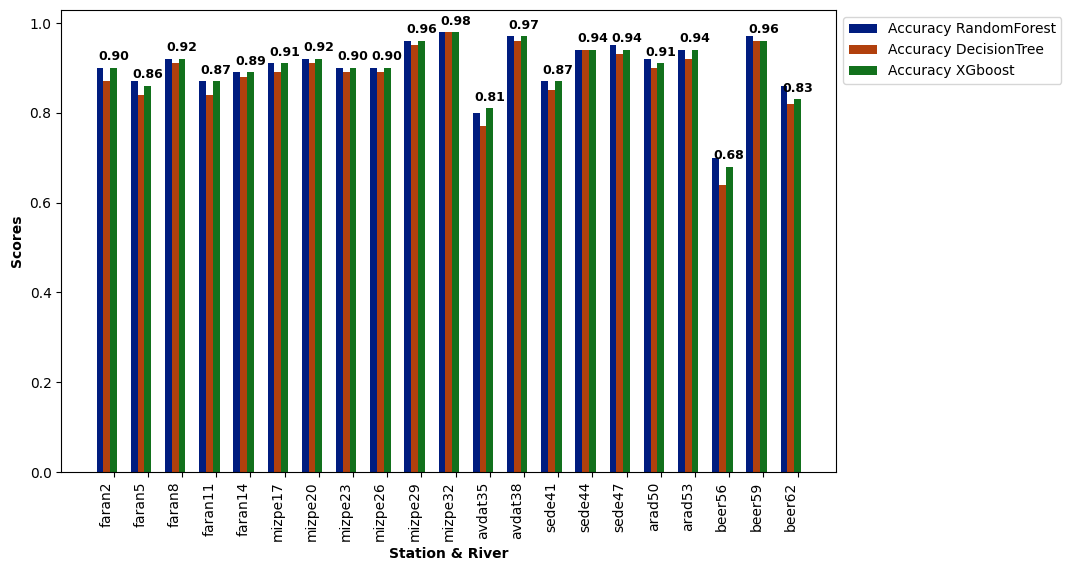

In [ ]:
# Filter the results dataframe by model type
random_forest_results = results_df[results_df['Model Name'].str.contains('RandomForest')]
decision_tree_results = results_df[results_df['Model Name'].str.contains('DecisionTree')]
xgboost_results = results_df[results_df['Model Name'].str.contains('XGBoost')]
random_forest_accuracy = [round(row['Accuracy'], 2) for i, row in random_forest_results.iterrows()]
decision_tree_accuracy = [round(row['Accuracy'], 2) for i, row in decision_tree_results.iterrows()]
xgboost_accuracy = [round(row['Accuracy'], 2) for i, row in xgboost_results.iterrows()]
# station_river_names = ['_'.join(name['Model Name'].split('_')[:-1]) for i, name in xgboost_results.iterrows()]
station_river_names = [name['Model Name'].split('_')[0] + str(i) for i, name in xgboost_results.iterrows()]

# station_river_names = list(set(station_river_names))


data = {
    'Station_River': station_river_names,
    'Accuracy RandomForest': random_forest_accuracy,
    'Accuracy DecisionTree': decision_tree_accuracy,
    'Accuracy XGboost': xgboost_accuracy
}

# Use Seaborn's dark color palette
sns.set_palette("dark")

fig, ax = plt.subplots(figsize=(10, 6))

for i, metric in enumerate(['Accuracy RandomForest', 'Accuracy DecisionTree', 'Accuracy XGboost']):
    bars = ax.bar(
        [x + i * 0.2 for x in range(len(data['Station_River']))],
        data[metric],
        width=0.2,
        label=metric
    )
    for bar in bars:
        if metric == 'Accuracy XGboost':
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.01,  # Adjust the vertical position for the text
                f'{height:.2f}',
                ha='center',
                va='bottom',
                fontsize=9,  # Adjust the font size
                weight='bold'  # Make the text bold
            )

ax.set_xlabel('Station & River', weight='bold')  # Make the xlabel bold
ax.set_ylabel('Scores', weight='bold')  # Make the ylabel bold
# ax.set_title('Inference Scores for Adults Dataset by Number of Missing Features', weight='bold')  # Make the title bold

# Set custom x-axis labels
ax.set_xticks([x + 0.4 for x in range(len(data['Station_River']))])
ax.set_xticklabels(station_river_names, rotation=90, ha='right')

# Adjust the legend position
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


## SHAP for selected model

In [ ]:
river_name = 'צין-במעלה מפל'
station_name = 'avdat'
with open(f"/content/drive/MyDrive/mikiProject/dataframes for models/{station_name}_{river_name}_df.pkl", 'rb') as file:
  data = pickle.load(file)
data['start_rain'] = pd.to_datetime(data['start_rain'])
data['start_month'] = data['start_rain'].dt.month
features = ['rain_amount', 'humidity', 'temperature', 'rain_variance', 'avg_of_rain_12h_before', 'avg_of_rain_3h_before', 'start_month']
target = 'flow'


X = data[features]
y = data[target]

# Combine the features and target into a single DataFrame
data = pd.concat([X, y], axis=1)

# Separate the majority and minority classes
majority_class = data[data['flow'] == 0]
minority_class = data[data['flow'] == 1]  # Assuming '1' represents the minority class

# Resample the minority class to match the number of samples in the majority class
minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)

# Combine the upsampled minority class with the majority class
balanced_data = pd.concat([majority_class, minority_upsampled])

# Separate the features (X) and target (y) from the balanced dataset
X_balanced = balanced_data[features]
y_balanced = balanced_data[target]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Create and train the Random Forest classification model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
# joblib.dump(model, f'{station_name}_{river_name}.pkl')
# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model (you can use different metrics as needed)
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)
print(f"station: {station_name}, river: {river_name}")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report_str)

station: avdat, river: צין-במעלה מפל
Accuracy: 0.8032498902064119
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.71      0.79      1166
           1       0.75      0.90      0.82      1111

    accuracy                           0.80      2277
   macro avg       0.81      0.81      0.80      2277
weighted avg       0.82      0.80      0.80      2277



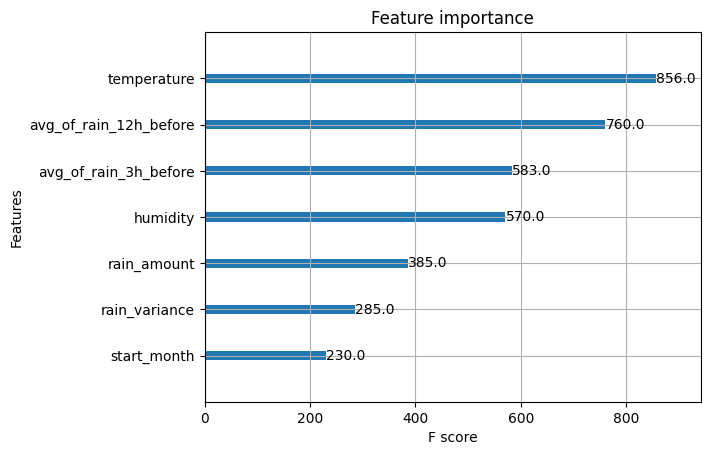

In [ ]:
# Plot feature importance
xgb.plot_importance(model, importance_type='weight')
plt.show()

In [ ]:
!pip install shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


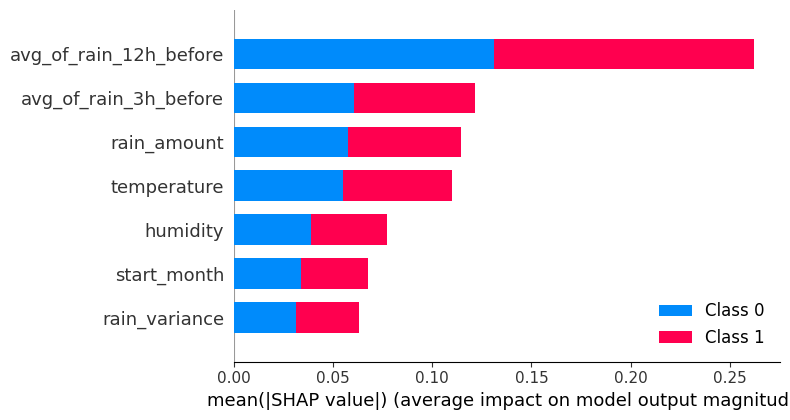

In [ ]:
import shap
# Explain the model predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test, check_additivity=False)
# Visualize summary plot of SHAP values for all predictions
shap.summary_plot(shap_values, X_test)

In [ ]:
# compute SHAP values
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test, check_additivity=False)

100%|===================| 4548/4554 [02:59<00:00]       

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


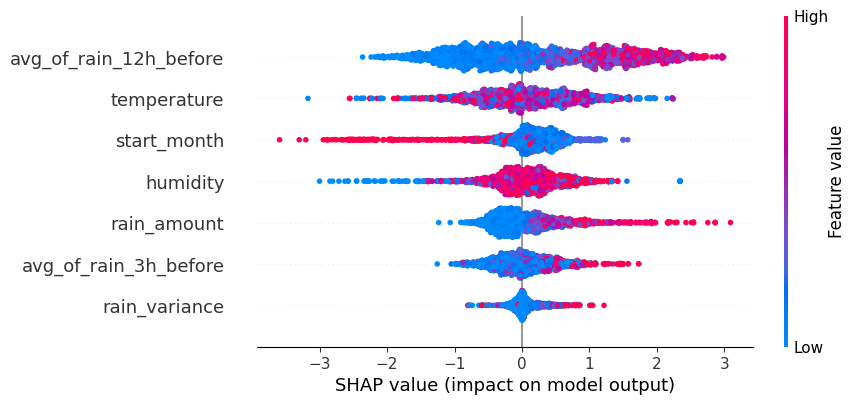

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
shap.plots.bar(shap_values)

## LIME for selected model

('avg_of_rain_12h_before <= 77.10', 'temperature <= 7.23', 'start_month <= 2.00', 'humidity <= 85.67', 'avg_of_rain_3h_before <= 5.10', 'rain_amount <= 0.10', 'rain_variance <= 0.00')
(-0.10021003672519516, -0.08605202532664834, 0.041797025675492566, -0.04148685904114137, 0.0410370437427713, -0.013948798696708144, -0.00999966313989577)


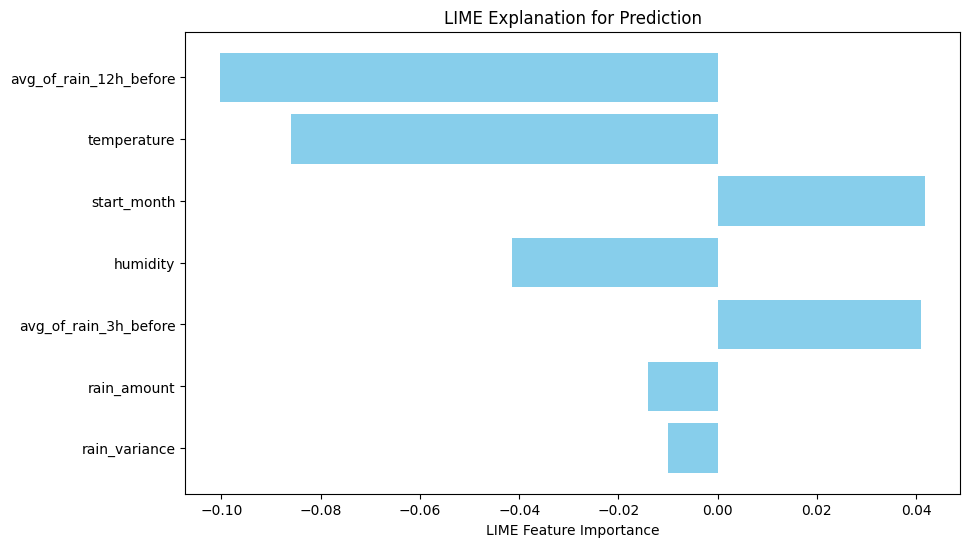

In [ ]:


# Create an explainer
explainer = LimeTabularExplainer(X_train.values, mode="classification", feature_names=X_train.columns)

# Explain a prediction
explanation = explainer.explain_instance(X_test.iloc[0].values, model.predict_proba, num_features=len(X_test.columns))

# Get the sorted feature importances and feature names
sorted_features = explanation.as_list()
feature_names, feature_values = zip(*sorted_features)
print(feature_names)
print(feature_values)
feature_values = np.array(feature_values)
feature_names = [f.split(' ')[0] for f in feature_names]
# Create a horizontal bar chart to visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_names)), feature_values, align='center', color='skyblue')
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('LIME Feature Importance')
plt.title('LIME Explanation for Prediction')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()
